# SIT-628-Final-Project  Dog vs. Cat

## Import Packages

In [123]:
import numpy as np 
import pandas as pd 
import os
import time
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from matplotlib import pyplot as plt
from datetime import timedelta
from sklearn import metrics

## Data preparation 

In [105]:
# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
#print('Pytorch dog-vs-cat-classification Training on {} '.format(device))
TRAIN = "Dataset/dogs-vs-cats/train"
VALID = "Dataset/dogs-vs-cats/valid"
TEST = "Dataset/dogs-vs-cats/test"
# print('train data_path=', TRAIN)
# print('valid data_path=', VALID)
# print('test data_path=', TEST)

Pytorch dog-vs-cat-classification Training on cpu 


## Data preprocessing

In [106]:
num_workers = 0
batch_size = 4
class_list = ['cat', 'dog']

# transform to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [107]:
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data=datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)
print(train_data.class_to_idx)
print(valid_data.class_to_idx)
print(test_data.class_to_idx)

{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}
{'test1': 0}


In [108]:
# load data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

## Data visualization

In [109]:
images,labels=next(iter(train_loader))
print(images.shape,labels.shape) 

torch.Size([4, 3, 224, 224]) torch.Size([4])


In [110]:
rgb_img = np.squeeze(images[3])
rgb_img.shape

torch.Size([3, 224, 224])

In [115]:
%matplotlib inline
classes = ['cat','dog']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])

def denormalize(image):
    #Normalize to (0,1)，function: (x-mean)/std，distribute to (-1,1)
    image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
    image = image.permute(1,2,0) 
    #3x224x224 -->224x224x3
    image = torch.clamp(image,0,1)
    return image

def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

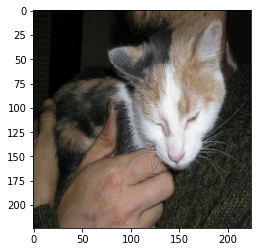

In [116]:
imshow(images[3])

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
img =  torch.Size([224, 224])
img =  torch.Size([224, 224])
img =  torch.Size([224, 224])


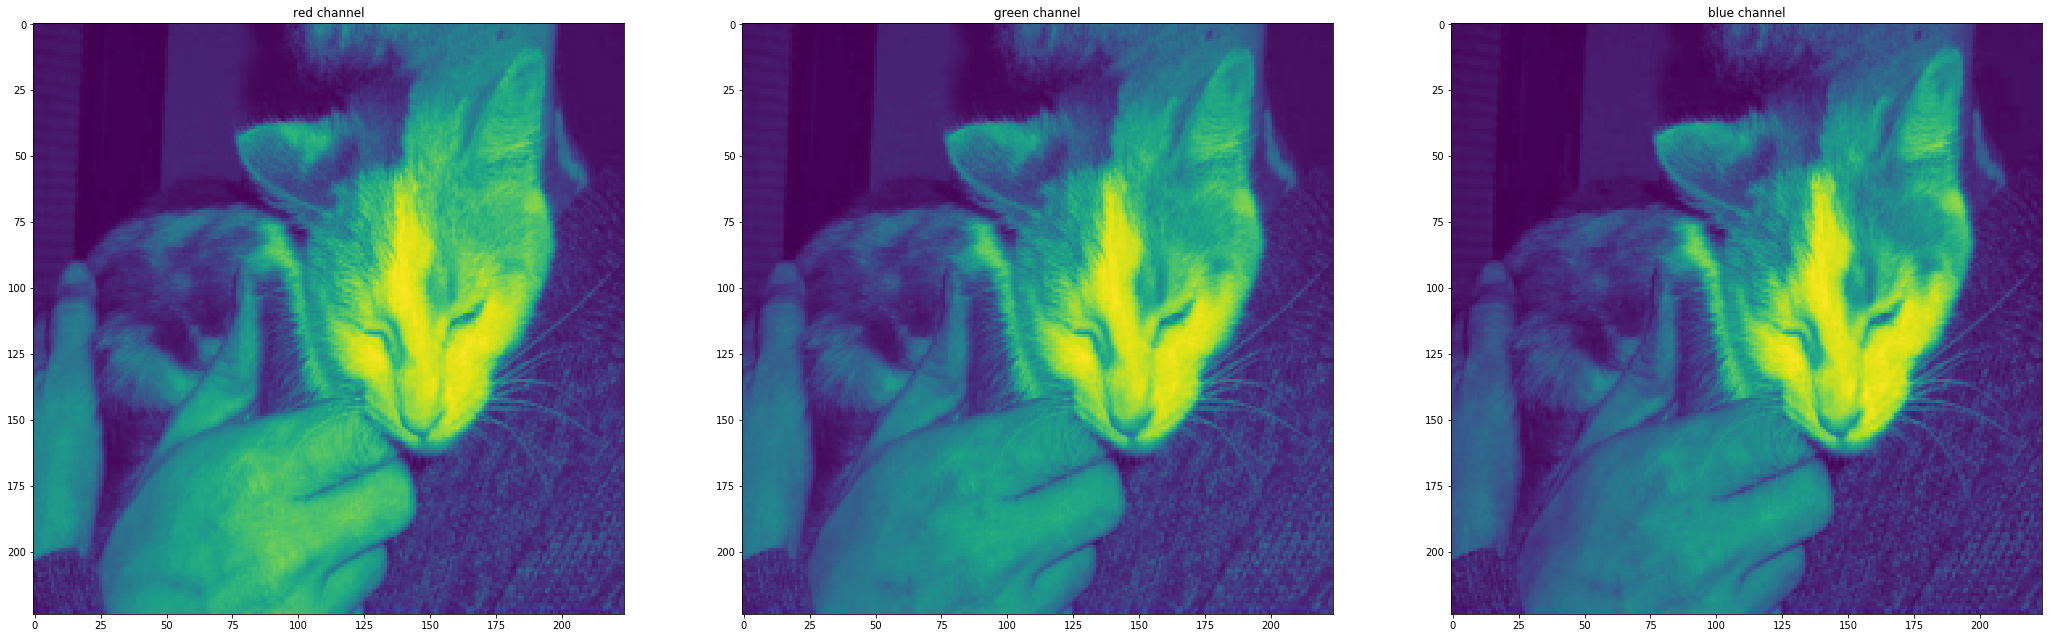

In [118]:
#Show images on 3 channels seperately
channels = ['red channel', 'green channel', 'blue channel']
print(images[3].shape)
rgb_img = np.squeeze(images[3])# delete the dimension with value equals to 1
print(rgb_img.shape)
num_channel = rgb_img.shape[0]
fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(num_channel):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    print('img = ',img.shape)
    ax.imshow(img) 
    ax.set_title(channels[idx])

img =  torch.Size([224, 224])
img =  torch.Size([224, 224])
img =  torch.Size([224, 224])


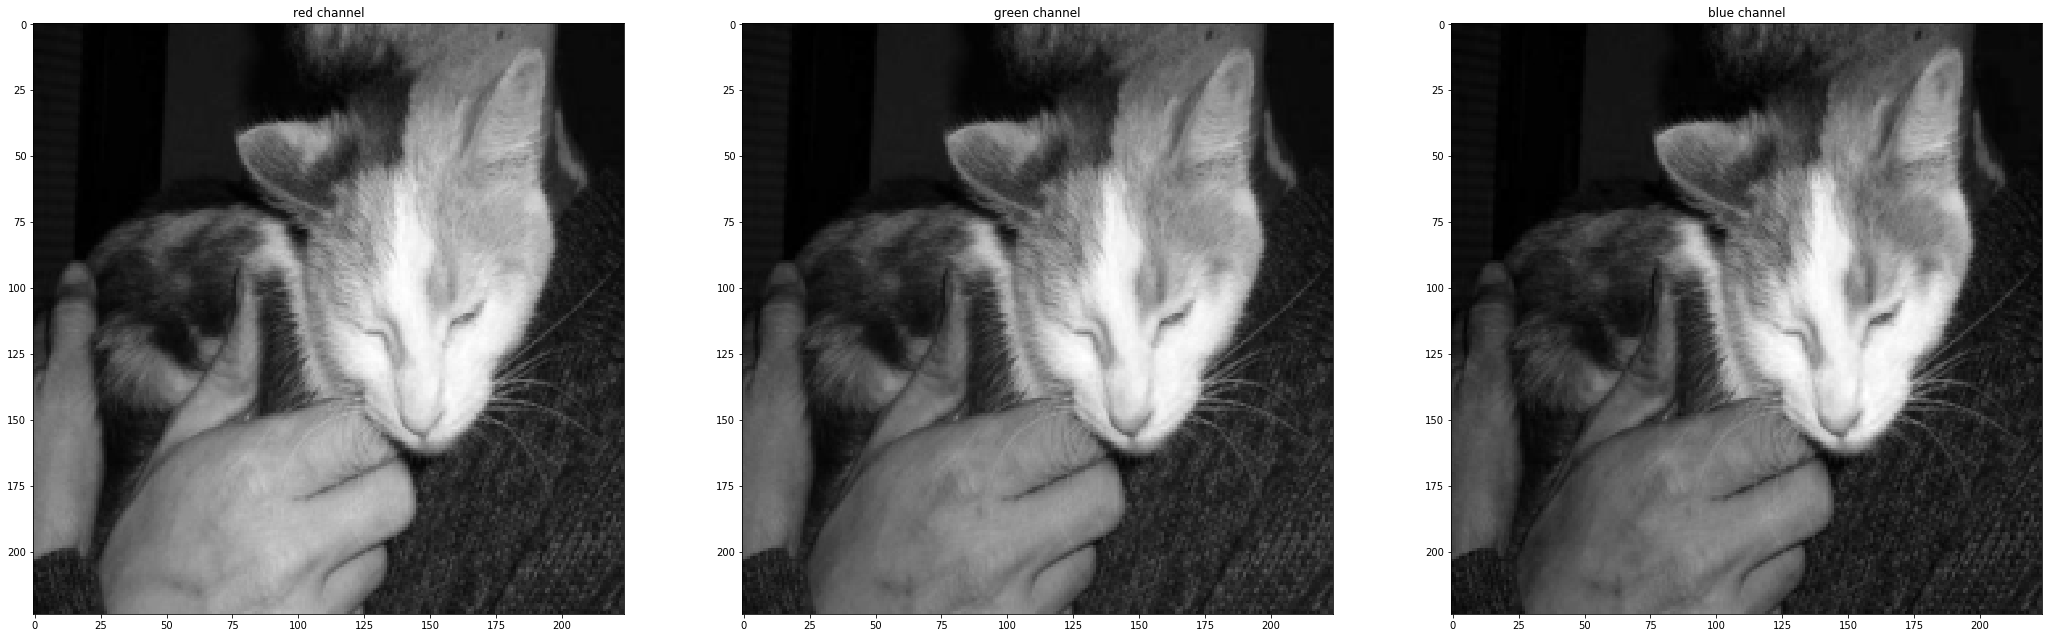

In [119]:
#gray images
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    print('img = ',img.shape)
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])

## Training and validating the model 

![](http://)Load the model VGG -19

In [120]:
vgg_19=models.vgg19_bn(pretrained=True)
vgg_19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

train the last layer, other layers are used to extract feature

In [121]:
for param in vgg_19.parameters():
    param.requires_grad = False
    
num_classes = 2
vgg_19.classifier[6] = nn.Linear(in_features = 4096, out_features= num_classes)
vgg_19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Define the loss function and optimizer

In [122]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(vgg_19.parameters(),lr=0.01)

train and validate the model

In [125]:
model_path = 'saved_dict' + '/model_vgg19.pth'
model = vgg_19
valid_best_loss = np.Inf  # track change in validation loss

train_total_batch = 0  
valid_total_batch = 0  
n_epochs = 3

for epoch in range(1, n_epochs + 1):
    print('[{}/{}] Training '.format(epoch,n_epochs))
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_running_examples = 0
    valid_running_examples = 0

    
# train the model
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # update training loss
        train_loss += loss.item() * targets.size(0)
        train_running_examples += targets.size(0)
        train_total_batch+=1
        
        if train_total_batch % 4 == 0:
            time_dif = get_time_dif(start_time)
            y_true = targets.data.cpu() 
            y_pred = torch.max(outputs.data, 1)[1].cpu()  
            train_acc = metrics.accuracy_score(y_true, y_pred)  
            print('Iter {} [{}/{}] - train examples={}\t train loss = {}\ttrain_acc={} '.format(
                train_total_batch,epoch, n_epochs, train_running_examples, loss, train_acc))
            
#validate the model
    model.eval()
    for inputs, targets in valid_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        valid_loss += loss.item() * inputs.size(0)
        valid_running_examples += targets.size(0)

        valid_total_batch += 1
        if valid_total_batch % 10 == 0:
            y_true = targets.data.cpu()  
            y_pred = torch.max(outputs.data, 1)[1].cpu()  
            valid_acc = metrics.accuracy_score(y_true, y_pred)  
            print('Iter {} [{}/{}] - valid examples={}\t valid loss = {}\tvalid_acc={}'.format(
                valid_total_batch,epoch,n_epochs,valid_running_examples,loss,valid_acc))

    # average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_best_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_best_loss,
            valid_loss))
        torch.save(model.state_dict(), model_path)
        valid_best_loss = valid_loss

[1/3] Training 
Iter 4 [1/3] - train examples=16	 train loss = 0.00017041119281202555	train_acc=1.0 
Iter 8 [1/3] - train examples=32	 train loss = 2.682194690351025e-06	train_acc=1.0 
Iter 12 [1/3] - train examples=48	 train loss = 1.0919040441513062	train_acc=0.75 
Iter 16 [1/3] - train examples=64	 train loss = 0.11793286353349686	train_acc=1.0 
Iter 20 [1/3] - train examples=80	 train loss = 0.00017866067355498672	train_acc=1.0 
Iter 10 [1/3] - valid examples=40	 valid loss = 0.0	valid_acc=1.0
Iter 20 [1/3] - valid examples=78	 valid loss = 0.0	valid_acc=1.0
Epoch: 1 	Training Loss: 0.155925 	Validation Loss: 0.349672
Validation loss decreased (inf --> 0.349672).  Saving model ...
[2/3] Training 
Iter 24 [2/3] - train examples=12	 train loss = 0.0005766352405771613	train_acc=1.0 
Iter 28 [2/3] - train examples=28	 train loss = 1.639124548091786e-06	train_acc=1.0 
Iter 32 [2/3] - train examples=44	 train loss = 4.768327926285565e-06	train_acc=1.0 
Iter 36 [2/3] - train examples=60	 

## Evaluate the model

In [127]:
def evaluate(model, data_iter, test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)

    for i, (outputs, targets) in enumerate(data_iter):
        outputs, targets = outputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(outputs)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, targets)
            loss_total += loss.item()
            targets = targets.data.cpu().numpy() 
            predic = torch.max(outputs.data, 1)[1].cpu().numpy() 
            labels_all = np.append(labels_all, targets) 
            predict_all = np.append(predict_all, predic)
    acc = metrics.accuracy_score(labels_all, predict_all)

    if test:
        report = metrics.classification_report(labels_all, predict_all, target_names=class_list, digits=4)
        confusion = metrics.confusion_matrix(labels_all, predict_all)
        return acc, loss_total / len(data_iter), report, confusion
    return acc, loss_total / len(data_iter)


def test(model, test_iter):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    start_time = time.time()
    test_acc, test_loss, test_report, test_confusion = evaluate(model, test_iter, test=True)
    msg = 'Test Loss: {0:>5.2},  Test Acc: {1:>6.2%}'
    print(msg.format(test_loss, test_acc))
    print("Precision, Recall and F1-Score...")
    print(test_report)
    print("Confusion Matrix...")
    print(test_confusion)
    time_dif = get_time_dif(start_time)
    print("Time usage:", time_dif)

In [128]:
model_path = 'saved_dict/model_vgg19.pth'
# Initialization
model_ft=models.vgg19_bn(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

    
num_classes = 2
model_ft.classifier[6] = nn.Linear(in_features = 4096, out_features= num_classes)
model_ft.load_state_dict(torch.load(model_path))
model_ft.eval()

print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [129]:
print(valid_data)
model_ft.to(device)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)

print('metris...')
test(model_ft,valid_loader)

Dataset ImageFolder
    Number of datapoints: 78
    Root location: input/dogs-vs-cats-for-pytorch/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
metris...
Test Loss:  0.12,  Test Acc: 97.44%
Precision, Recall and F1-Score...
              precision    recall  f1-score   support

         cat     0.9825    0.9825    0.9825        57
         dog     0.9524    0.9524    0.9524        21

    accuracy                         0.9744        78
   macro avg     0.9674    0.9674    0.9674        78
weighted avg     0.9744    0.9744    0.9744        78

Confusion Matrix...
[[56  1]
 [ 1 20]]
Time usage: 0:00:45


Visualize part of validating result

Dataset ImageFolder
    Number of datapoints: 78
    Root location: input/dogs-vs-cats-for-pytorch/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
torch.Size([32, 3, 224, 224])
torch.Size([32])
preds_tensor =  tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1])
preds_tensor numpy =  [0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1]
preds =  [0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1]


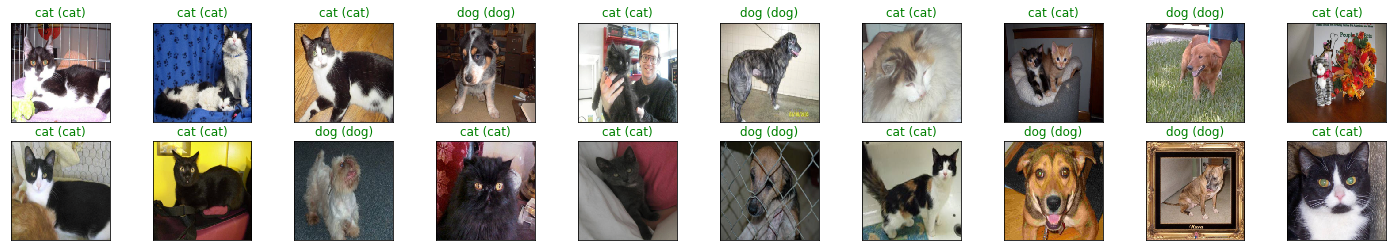

In [130]:
batch_size=32
print(valid_data)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
model_ft.cpu()
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
# get sample outputs
output = model_ft(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
print('preds_tensor = ',preds_tensor)
print('preds_tensor numpy = ',preds_tensor.numpy())
preds = np.squeeze(preds_tensor.numpy())
print('preds = ',preds)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(class_list[preds[idx]], class_list[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Predict the test data

In [156]:
from PIL import Image
def load_model():
    model_path = 'saved_dict/model_vgg19.pth'
    model_ft = models.vgg19_bn(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False
    num_classes = 2
    model_ft.classifier[6] = nn.Linear(in_features = 4096, out_features= num_classes)
    model_ft.load_state_dict(torch.load(model_path, map_location='cpu'))
    model_ft.eval()

#     print('load model time = {} s'.format(time.time() - start_time))
    return model_ft


model_ft = load_model()
print(model_ft)

def transform_image(img_path):
    data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
    image = Image.open(img_path)
    vector = data_transforms(image).unsqueeze(0)
    return vector


def get_prediction(img_path):
    tensor = transform_image(img_path)
    outputs = model_ft.forward(tensor)
    _, y_hat = outputs.max(1)
    predicted_idx = y_hat.item()
    return predicted_idx,class_list[predicted_idx]


def predict(img_path):
    start_time = time.time()
    class_id, class_name = get_prediction(img_path)
    ts = time.time() - start_time
    return {'label_id': class_id, 'label_name': class_name,"consume": int(ts*1000) }


TEST = "Dataset/dogs-vs-cats/test/1/"
files = os.listdir(TEST)
rows = []
for file in files:
    if not os.path.isdir(file):
        file_arr = file.split(".")
        if file_arr[1] == 'jpg':
            predicted = {**{'id': file_arr[0]}, **predict(TEST + file)}
            rows.append(predicted)
            print(predicted)



path = "sample_submission.csv"
with open(path, 'w') as f:
    csv_write = csv.writer(f)
    csv_head = ["id","label"]
    csv_write.writerow(csv_head)
    for row in rows:
        csv_write.writerow([row['id'], row['label_id']])

load model time = 57380.597794771194 s
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

{'id': '2896', 'label_id': 0, 'label_name': 'cat', 'consume': 636}
{'id': '3550', 'label_id': 1, 'label_name': 'dog', 'consume': 639}
{'id': '11017', 'label_id': 0, 'label_name': 'cat', 'consume': 631}
{'id': '10309', 'label_id': 0, 'label_name': 'cat', 'consume': 633}
{'id': '5121', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '9928', 'label_id': 0, 'label_name': 'cat', 'consume': 626}
{'id': '638', 'label_id': 0, 'label_name': 'cat', 'consume': 632}
{'id': '7905', 'label_id': 0, 'label_name': 'cat', 'consume': 643}
{'id': '9096', 'label_id': 0, 'label_name': 'cat', 'consume': 636}
{'id': '8388', 'label_id': 1, 'label_name': 'dog', 'consume': 638}
{'id': '12293', 'label_id': 0, 'label_name': 'cat', 'consume': 631}
{'id': '5874', 'label_id': 1, 'label_name': 'dog', 'consume': 640}
{'id': '11942', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '10484', 'label_id': 1, 'label_name': 'dog', 'consume': 643}
{'id': '5860', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '3785', 'label_id': 1, 'label_name': 'dog', 'consume': 615}
{'id': '406', 'label_id': 1, 'label_name': 'dog', 'consume': 581}
{'id': '1192', 'label_id': 0, 'label_name': 'cat', 'consume': 596}
{'id': '8808', 'label_id': 0, 'label_name': 'cat', 'consume': 593}
{'id': '6825', 'label_id': 1, 'label_name': 'dog', 'consume': 603}
{'id': '1186', 'label_id': 1, 'label_name': 'dog', 'consume': 591}
{'id': '412', 'label_id': 1, 'label_name': 'dog', 'consume': 588}
{'id': '6831', 'label_id': 1, 'label_name': 'dog', 'consume': 593}
{'id': '3791', 'label_id': 0, 'label_name': 'cat', 'consume': 597}
{'id': '3949', 'label_id': 1, 'label_name': 'dog', 'consume': 599}
{'id': '4940', 'label_id': 1, 'label_name': 'dog', 'consume': 596}
{'id': '5486', 'label_id': 0, 'label_name': 'cat', 'consume': 597}
{'id': '4798', 'label_id': 0, 'label_name': 'cat', 'consume': 613}
{'id': '10876', 'label_id': 1, 'label_name': 'dog', 'consume': 614}
{'id': '1838', 'label_id': 1, 'label_name': 'dog', 'consume': 6

{'id': '4363', 'label_id': 0, 'label_name': 'cat', 'consume': 606}
{'id': '4405', 'label_id': 1, 'label_name': 'dog', 'consume': 596}
{'id': '10533', 'label_id': 0, 'label_name': 'cat', 'consume': 591}
{'id': '2074', 'label_id': 0, 'label_name': 'cat', 'consume': 610}
{'id': '9121', 'label_id': 0, 'label_name': 'cat', 'consume': 594}
{'id': '6212', 'label_id': 0, 'label_name': 'cat', 'consume': 614}
{'id': '12324', 'label_id': 0, 'label_name': 'cat', 'consume': 599}
{'id': '9135', 'label_id': 1, 'label_name': 'dog', 'consume': 608}
{'id': '6206', 'label_id': 1, 'label_name': 'dog', 'consume': 627}
{'id': '1569', 'label_id': 1, 'label_name': 'dog', 'consume': 592}
{'id': '12330', 'label_id': 0, 'label_name': 'cat', 'consume': 605}
{'id': '7118', 'label_id': 0, 'label_name': 'cat', 'consume': 593}
{'id': '4411', 'label_id': 1, 'label_name': 'dog', 'consume': 599}
{'id': '11639', 'label_id': 0, 'label_name': 'cat', 'consume': 613}
{'id': '10527', 'label_id': 0, 'label_name': 'cat', 'consu

{'id': '5901', 'label_id': 1, 'label_name': 'dog', 'consume': 630}
{'id': '11837', 'label_id': 0, 'label_name': 'cat', 'consume': 625}
{'id': '8216', 'label_id': 1, 'label_name': 'dog', 'consume': 641}
{'id': '7125', 'label_id': 0, 'label_name': 'cat', 'consume': 639}
{'id': '1554', 'label_id': 1, 'label_name': 'dog', 'consume': 619}
{'id': '9108', 'label_id': 1, 'label_name': 'dog', 'consume': 617}
{'id': '5732', 'label_id': 1, 'label_name': 'dog', 'consume': 613}
{'id': '11604', 'label_id': 1, 'label_name': 'dog', 'consume': 603}
{'id': '3343', 'label_id': 0, 'label_name': 'cat', 'consume': 596}
{'id': '11162', 'label_id': 0, 'label_name': 'cat', 'consume': 619}
{'id': '3425', 'label_id': 1, 'label_name': 'dog', 'consume': 601}
{'id': '5054', 'label_id': 0, 'label_name': 'cat', 'consume': 612}
{'id': '1232', 'label_id': 1, 'label_name': 'dog', 'consume': 606}
{'id': '8570', 'label_id': 0, 'label_name': 'cat', 'consume': 615}
{'id': '7643', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '5524', 'label_id': 1, 'label_name': 'dog', 'consume': 615}
{'id': '5242', 'label_id': 1, 'label_name': 'dog', 'consume': 628}
{'id': '3633', 'label_id': 1, 'label_name': 'dog', 'consume': 632}
{'id': '11374', 'label_id': 0, 'label_name': 'cat', 'consume': 626}
{'id': '7455', 'label_id': 1, 'label_name': 'dog', 'consume': 682}
{'id': '8766', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '6993', 'label_id': 0, 'label_name': 'cat', 'consume': 625}
{'id': '1024', 'label_id': 0, 'label_name': 'cat', 'consume': 629}
{'id': '9478', 'label_id': 1, 'label_name': 'dog', 'consume': 621}
{'id': '10042', 'label_id': 0, 'label_name': 'cat', 'consume': 616}
{'id': '2505', 'label_id': 1, 'label_name': 'dog', 'consume': 617}
{'id': '4174', 'label_id': 1, 'label_name': 'dog', 'consume': 612}
{'id': '8996', 'label_id': 0, 'label_name': 'cat', 'consume': 614}
{'id': '598', 'label_id': 0, 'label_name': 'cat', 'consume': 615}
{'id': '9450', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '3009', 'label_id': 1, 'label_name': 'dog', 'consume': 624}
{'id': '10888', 'label_id': 1, 'label_name': 'dog', 'consume': 618}
{'id': '4766', 'label_id': 0, 'label_name': 'cat', 'consume': 635}
{'id': '10644', 'label_id': 1, 'label_name': 'dog', 'consume': 646}
{'id': '2303', 'label_id': 0, 'label_name': 'cat', 'consume': 640}
{'id': '4772', 'label_id': 1, 'label_name': 'dog', 'consume': 627}
{'id': '8148', 'label_id': 1, 'label_name': 'dog', 'consume': 610}
{'id': '12053', 'label_id': 0, 'label_name': 'cat', 'consume': 616}
{'id': '9256', 'label_id': 0, 'label_name': 'cat', 'consume': 641}
{'id': '6165', 'label_id': 0, 'label_name': 'cat', 'consume': 708}
{'id': '9530', 'label_id': 1, 'label_name': 'dog', 'consume': 641}
{'id': '6603', 'label_id': 0, 'label_name': 'cat', 'consume': 628}
{'id': '4014', 'label_id': 0, 'label_name': 'cat', 'consume': 614}
{'id': '10122', 'label_id': 0, 'label_name': 'cat', 'consume': 638}
{'id': '2465', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '74', 'label_id': 1, 'label_name': 'dog', 'consume': 619}
{'id': '6417', 'label_id': 0, 'label_name': 'cat', 'consume': 600}
{'id': '9724', 'label_id': 0, 'label_name': 'cat', 'consume': 612}
{'id': '1378', 'label_id': 1, 'label_name': 'dog', 'consume': 616}
{'id': '7709', 'label_id': 0, 'label_name': 'cat', 'consume': 609}
{'id': '834', 'label_id': 1, 'label_name': 'dog', 'consume': 623}
{'id': '12247', 'label_id': 1, 'label_name': 'dog', 'consume': 619}
{'id': '6371', 'label_id': 0, 'label_name': 'cat', 'consume': 626}
{'id': '9042', 'label_id': 0, 'label_name': 'cat', 'consume': 622}
{'id': '5678', 'label_id': 0, 'label_name': 'cat', 'consume': 607}
{'id': '11996', 'label_id': 0, 'label_name': 'cat', 'consume': 620}
{'id': '2117', 'label_id': 1, 'label_name': 'dog', 'consume': 620}
{'id': '10450', 'label_id': 0, 'label_name': 'cat', 'consume': 615}
{'id': '3209', 'label_id': 1, 'label_name': 'dog', 'consume': 618}
{'id': '4566', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '10646', 'label_id': 1, 'label_name': 'dog', 'consume': 632}
{'id': '2301', 'label_id': 1, 'label_name': 'dog', 'consume': 632}
{'id': '1620', 'label_id': 1, 'label_name': 'dog', 'consume': 610}
{'id': '12079', 'label_id': 1, 'label_name': 'dog', 'consume': 620}
{'id': '7251', 'label_id': 1, 'label_name': 'dog', 'consume': 631}
{'id': '8162', 'label_id': 1, 'label_name': 'dog', 'consume': 616}
{'id': '4758', 'label_id': 0, 'label_name': 'cat', 'consume': 628}
{'id': '3037', 'label_id': 1, 'label_name': 'dog', 'consume': 623}
{'id': '11570', 'label_id': 0, 'label_name': 'cat', 'consume': 634}
{'id': '2329', 'label_id': 0, 'label_name': 'cat', 'consume': 638}
{'id': '4980', 'label_id': 1, 'label_name': 'dog', 'consume': 626}
{'id': '5446', 'label_id': 1, 'label_name': 'dog', 'consume': 615}
{'id': '3989', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '5320', 'label_id': 1, 'label_name': 'dog', 'consume': 622}
{'id': '10108', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '5240', 'label_id': 0, 'label_name': 'cat', 'consume': 616}
{'id': '5526', 'label_id': 1, 'label_name': 'dog', 'consume': 614}
{'id': '2249', 'label_id': 0, 'label_name': 'cat', 'consume': 603}
{'id': '3157', 'label_id': 1, 'label_name': 'dog', 'consume': 606}
{'id': '11410', 'label_id': 0, 'label_name': 'cat', 'consume': 591}
{'id': '4638', 'label_id': 0, 'label_name': 'cat', 'consume': 599}
{'id': '7331', 'label_id': 0, 'label_name': 'cat', 'consume': 594}
{'id': '8002', 'label_id': 0, 'label_name': 'cat', 'consume': 611}
{'id': '1998', 'label_id': 1, 'label_name': 'dog', 'consume': 610}
{'id': '12119', 'label_id': 0, 'label_name': 'cat', 'consume': 608}
{'id': '1740', 'label_id': 0, 'label_name': 'cat', 'consume': 603}
{'id': '1973', 'label_id': 0, 'label_name': 'cat', 'consume': 618}
{'id': '10083', 'label_id': 0, 'label_name': 'cat', 'consume': 595}
{'id': '3802', 'label_id': 1, 'label_name': 'dog', 'consume': 603}
{'id': '9491', 'label_id': 0, 'label_name': 'cat', 'consume

{'id': '12482', 'label_id': 0, 'label_name': 'cat', 'consume': 689}
{'id': '2922', 'label_id': 0, 'label_name': 'cat', 'consume': 632}
{'id': '5095', 'label_id': 0, 'label_name': 'cat', 'consume': 615}
{'id': '767', 'label_id': 1, 'label_name': 'dog', 'consume': 616}
{'id': '7682', 'label_id': 0, 'label_name': 'cat', 'consume': 623}
{'id': '9877', 'label_id': 0, 'label_name': 'cat', 'consume': 624}
{'id': '1595', 'label_id': 0, 'label_name': 'cat', 'consume': 612}
{'id': '3382', 'label_id': 0, 'label_name': 'cat', 'consume': 595}
{'id': '2088', 'label_id': 0, 'label_name': 'cat', 'consume': 640}
{'id': '11809', 'label_id': 1, 'label_name': 'dog', 'consume': 605}
{'id': '3396', 'label_id': 1, 'label_name': 'dog', 'consume': 608}
{'id': '1581', 'label_id': 1, 'label_name': 'dog', 'consume': 620}
{'id': '773', 'label_id': 1, 'label_name': 'dog', 'consume': 588}
{'id': '6588', 'label_id': 1, 'label_name': 'dog', 'consume': 608}
{'id': '7696', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '1782', 'label_id': 1, 'label_name': 'dog', 'consume': 622}
{'id': '216', 'label_id': 1, 'label_name': 'dog', 'consume': 621}
{'id': '202', 'label_id': 0, 'label_name': 'cat', 'consume': 637}
{'id': '1796', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '4836', 'label_id': 1, 'label_name': 'dog', 'consume': 631}
{'id': '10900', 'label_id': 1, 'label_name': 'dog', 'consume': 653}
{'id': '3181', 'label_id': 1, 'label_name': 'dog', 'consume': 697}
{'id': '4188', 'label_id': 0, 'label_name': 'cat', 'consume': 693}
{'id': '5296', 'label_id': 0, 'label_name': 'cat', 'consume': 674}
{'id': '564', 'label_id': 0, 'label_name': 'cat', 'consume': 672}
{'id': '7481', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '6947', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '11388', 'label_id': 0, 'label_name': 'cat', 'consume': 669}
{'id': '3817', 'label_id': 1, 'label_name': 'dog', 'consume': 634}
{'id': '10096', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '11203', 'label_id': 0, 'label_name': 'cat', 'consume': 626}
{'id': '3744', 'label_id': 1, 'label_name': 'dog', 'consume': 633}
{'id': '5335', 'label_id': 0, 'label_name': 'cat', 'consume': 613}
{'id': '1153', 'label_id': 0, 'label_name': 'cat', 'consume': 615}
{'id': '8611', 'label_id': 1, 'label_name': 'dog', 'consume': 615}
{'id': '7522', 'label_id': 0, 'label_name': 'cat', 'consume': 639}
{'id': '8177', 'label_id': 1, 'label_name': 'dog', 'consume': 624}
{'id': '7244', 'label_id': 0, 'label_name': 'cat', 'consume': 647}
{'id': '1635', 'label_id': 1, 'label_name': 'dog', 'consume': 638}
{'id': '9269', 'label_id': 1, 'label_name': 'dog', 'consume': 638}
{'id': '5453', 'label_id': 0, 'label_name': 'cat', 'consume': 642}
{'id': '4995', 'label_id': 0, 'label_name': 'cat', 'consume': 697}
{'id': '11565', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '3022', 'label_id': 0, 'label_name': 'cat', 'consume': 639}
{'id': '5447', 'label_id': 1, 'label_name': 'dog', 'consume'

{'id': '7052', 'label_id': 1, 'label_name': 'dog', 'consume': 627}
{'id': '8361', 'label_id': 1, 'label_name': 'dog', 'consume': 611}
{'id': '3234', 'label_id': 0, 'label_name': 'cat', 'consume': 643}
{'id': '11773', 'label_id': 1, 'label_name': 'dog', 'consume': 628}
{'id': '5645', 'label_id': 0, 'label_name': 'cat', 'consume': 644}
{'id': '9057', 'label_id': 0, 'label_name': 'cat', 'consume': 638}
{'id': '6364', 'label_id': 0, 'label_name': 'cat', 'consume': 635}
{'id': '12252', 'label_id': 0, 'label_name': 'cat', 'consume': 624}
{'id': '8349', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '4573', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '10445', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '2102', 'label_id': 1, 'label_name': 'dog', 'consume': 643}
{'id': '11983', 'label_id': 0, 'label_name': 'cat', 'consume': 648}
{'id': '10323', 'label_id': 1, 'label_name': 'dog', 'consume': 650}
{'id': '2664', 'label_id': 1, 'label_name': 'dog', 'consu

{'id': '164', 'label_id': 1, 'label_name': 'dog', 'consume': 608}
{'id': '7081', 'label_id': 1, 'label_name': 'dog', 'consume': 614}
{'id': '5866', 'label_id': 0, 'label_name': 'cat', 'consume': 607}
{'id': '11788', 'label_id': 0, 'label_name': 'cat', 'consume': 621}
{'id': '10496', 'label_id': 1, 'label_name': 'dog', 'consume': 619}
{'id': '11950', 'label_id': 0, 'label_name': 'cat', 'consume': 607}
{'id': '9084', 'label_id': 1, 'label_name': 'dog', 'consume': 608}
{'id': '12281', 'label_id': 1, 'label_name': 'dog', 'consume': 625}
{'id': '7917', 'label_id': 0, 'label_name': 'cat', 'consume': 609}
{'id': '7903', 'label_id': 1, 'label_name': 'dog', 'consume': 631}
{'id': '9090', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '158', 'label_id': 1, 'label_name': 'dog', 'consume': 686}
{'id': '12295', 'label_id': 0, 'label_name': 'cat', 'consume': 644}
{'id': '5872', 'label_id': 0, 'label_name': 'cat', 'consume': 637}
{'id': '10482', 'label_id': 0, 'label_name': 'cat', 'consum

{'id': '12108', 'label_id': 1, 'label_name': 'dog', 'consume': 605}
{'id': '7320', 'label_id': 0, 'label_name': 'cat', 'consume': 630}
{'id': '8013', 'label_id': 0, 'label_name': 'cat', 'consume': 624}
{'id': '1989', 'label_id': 1, 'label_name': 'dog', 'consume': 601}
{'id': '1751', 'label_id': 1, 'label_name': 'dog', 'consume': 598}
{'id': '2258', 'label_id': 0, 'label_name': 'cat', 'consume': 598}
{'id': '5537', 'label_id': 0, 'label_name': 'cat', 'consume': 613}
{'id': '4629', 'label_id': 0, 'label_name': 'cat', 'consume': 607}
{'id': '3146', 'label_id': 0, 'label_name': 'cat', 'consume': 603}
{'id': '11401', 'label_id': 0, 'label_name': 'cat', 'consume': 612}
{'id': '5523', 'label_id': 0, 'label_name': 'cat', 'consume': 612}
{'id': '3152', 'label_id': 1, 'label_name': 'dog', 'consume': 609}
{'id': '11415', 'label_id': 0, 'label_name': 'cat', 'consume': 628}
{'id': '7334', 'label_id': 1, 'label_name': 'dog', 'consume': 621}
{'id': '8007', 'label_id': 0, 'label_name': 'cat', 'consume

{'id': '5709', 'label_id': 0, 'label_name': 'cat', 'consume': 616}
{'id': '2066', 'label_id': 0, 'label_name': 'cat', 'consume': 600}
{'id': '10521', 'label_id': 0, 'label_name': 'cat', 'consume': 680}
{'id': '2700', 'label_id': 1, 'label_name': 'dog', 'consume': 627}
{'id': '10247', 'label_id': 1, 'label_name': 'dog', 'consume': 621}
{'id': '4371', 'label_id': 0, 'label_name': 'cat', 'consume': 616}
{'id': '11159', 'label_id': 1, 'label_name': 'dog', 'consume': 622}
{'id': '12450', 'label_id': 0, 'label_name': 'cat', 'consume': 594}
{'id': '7678', 'label_id': 1, 'label_name': 'dog', 'consume': 609}
{'id': '945', 'label_id': 1, 'label_name': 'dog', 'consume': 607}
{'id': '6566', 'label_id': 1, 'label_name': 'dog', 'consume': 617}
{'id': '9655', 'label_id': 1, 'label_name': 'dog', 'consume': 597}
{'id': '1209', 'label_id': 0, 'label_name': 'cat', 'consume': 586}
{'id': '12444', 'label_id': 1, 'label_name': 'dog', 'consume': 611}
{'id': '9899', 'label_id': 0, 'label_name': 'cat', 'consum

{'id': '11158', 'label_id': 0, 'label_name': 'cat', 'consume': 616}
{'id': '4370', 'label_id': 1, 'label_name': 'dog', 'consume': 617}
{'id': '10246', 'label_id': 0, 'label_name': 'cat', 'consume': 618}
{'id': '2701', 'label_id': 0, 'label_name': 'cat', 'consume': 606}
{'id': '7889', 'label_id': 0, 'label_name': 'cat', 'consume': 620}
{'id': '1220', 'label_id': 0, 'label_name': 'cat', 'consume': 616}
{'id': '7651', 'label_id': 0, 'label_name': 'cat', 'consume': 623}
{'id': '8562', 'label_id': 1, 'label_name': 'dog', 'consume': 675}
{'id': '12479', 'label_id': 0, 'label_name': 'cat', 'consume': 626}
{'id': '3437', 'label_id': 1, 'label_name': 'dog', 'consume': 615}
{'id': '11170', 'label_id': 1, 'label_name': 'dog', 'consume': 605}
{'id': '4358', 'label_id': 1, 'label_name': 'dog', 'consume': 605}
{'id': '5046', 'label_id': 1, 'label_name': 'dog', 'consume': 603}
{'id': '2729', 'label_id': 0, 'label_name': 'cat', 'consume': 615}
{'id': '10508', 'label_id': 0, 'label_name': 'cat', 'consu

{'id': '3147', 'label_id': 1, 'label_name': 'dog', 'consume': 628}
{'id': '4628', 'label_id': 1, 'label_name': 'dog', 'consume': 618}
{'id': '5536', 'label_id': 1, 'label_name': 'dog', 'consume': 623}
{'id': '2259', 'label_id': 1, 'label_name': 'dog', 'consume': 621}
{'id': '1750', 'label_id': 0, 'label_name': 'cat', 'consume': 608}
{'id': '8012', 'label_id': 0, 'label_name': 'cat', 'consume': 614}
{'id': '1988', 'label_id': 0, 'label_name': 'cat', 'consume': 626}
{'id': '7321', 'label_id': 1, 'label_name': 'dog', 'consume': 614}
{'id': '12109', 'label_id': 1, 'label_name': 'dog', 'consume': 610}
{'id': '9293', 'label_id': 0, 'label_name': 'cat', 'consume': 618}
{'id': '12096', 'label_id': 1, 'label_name': 'dog', 'consume': 618}
{'id': '1817', 'label_id': 1, 'label_name': 'dog', 'consume': 620}
{'id': '10859', 'label_id': 1, 'label_name': 'dog', 'consume': 611}
{'id': '10681', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '3966', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '603', 'label_id': 0, 'label_name': 'cat', 'consume': 629}
{'id': '1397', 'label_id': 0, 'label_name': 'cat', 'consume': 626}
{'id': '9913', 'label_id': 0, 'label_name': 'cat', 'consume': 622}
{'id': '7080', 'label_id': 1, 'label_name': 'dog', 'consume': 628}
{'id': '165', 'label_id': 0, 'label_name': 'cat', 'consume': 635}
{'id': '11979', 'label_id': 1, 'label_name': 'dog', 'consume': 631}
{'id': '5697', 'label_id': 1, 'label_name': 'dog', 'consume': 635}
{'id': '4589', 'label_id': 0, 'label_name': 'cat', 'consume': 625}
{'id': '5683', 'label_id': 0, 'label_name': 'cat', 'consume': 637}
{'id': '7094', 'label_id': 0, 'label_name': 'cat', 'consume': 641}
{'id': '171', 'label_id': 0, 'label_name': 'cat', 'consume': 620}
{'id': '1383', 'label_id': 0, 'label_name': 'cat', 'consume': 611}
{'id': '617', 'label_id': 1, 'label_name': 'dog', 'consume': 620}
{'id': '9907', 'label_id': 0, 'label_name': 'cat', 'consume': 622}
{'id': '2852', 'label_id': 0, 'label_name': 'cat', 'consume': 613

{'id': '6363', 'label_id': 1, 'label_name': 'dog', 'consume': 627}
{'id': '198', 'label_id': 0, 'label_name': 'cat', 'consume': 628}
{'id': '9736', 'label_id': 0, 'label_name': 'cat', 'consume': 609}
{'id': '6405', 'label_id': 0, 'label_name': 'cat', 'consume': 604}
{'id': '66', 'label_id': 1, 'label_name': 'dog', 'consume': 608}
{'id': '8428', 'label_id': 0, 'label_name': 'cat', 'consume': 617}
{'id': '826', 'label_id': 1, 'label_name': 'dog', 'consume': 631}
{'id': '4212', 'label_id': 0, 'label_name': 'cat', 'consume': 597}
{'id': '10324', 'label_id': 1, 'label_name': 'dog', 'consume': 607}
{'id': '2663', 'label_id': 1, 'label_name': 'dog', 'consume': 614}
{'id': '3569', 'label_id': 1, 'label_name': 'dog', 'consume': 608}
{'id': '4206', 'label_id': 1, 'label_name': 'dog', 'consume': 631}
{'id': '5118', 'label_id': 1, 'label_name': 'dog', 'consume': 600}
{'id': '10330', 'label_id': 0, 'label_name': 'cat', 'consume': 601}
{'id': '2677', 'label_id': 0, 'label_name': 'cat', 'consume': 59

{'id': '2475', 'label_id': 0, 'label_name': 'cat', 'consume': 611}
{'id': '10132', 'label_id': 0, 'label_name': 'cat', 'consume': 607}
{'id': '4004', 'label_id': 0, 'label_name': 'cat', 'consume': 626}
{'id': '3780', 'label_id': 1, 'label_name': 'dog', 'consume': 620}
{'id': '3958', 'label_id': 0, 'label_name': 'cat', 'consume': 616}
{'id': '403', 'label_id': 1, 'label_name': 'dog', 'consume': 594}
{'id': '1197', 'label_id': 1, 'label_name': 'dog', 'consume': 620}
{'id': '6820', 'label_id': 1, 'label_name': 'dog', 'consume': 592}
{'id': '1829', 'label_id': 1, 'label_name': 'dog', 'consume': 623}
{'id': '7280', 'label_id': 1, 'label_name': 'dog', 'consume': 634}
{'id': '365', 'label_id': 1, 'label_name': 'dog', 'consume': 620}
{'id': '5497', 'label_id': 1, 'label_name': 'dog', 'consume': 608}
{'id': '4951', 'label_id': 0, 'label_name': 'cat', 'consume': 620}
{'id': '4789', 'label_id': 0, 'label_name': 'cat', 'consume': 609}
{'id': '10867', 'label_id': 0, 'label_name': 'cat', 'consume': 

{'id': '6798', 'label_id': 0, 'label_name': 'cat', 'consume': 620}
{'id': '5291', 'label_id': 1, 'label_name': 'dog', 'consume': 634}
{'id': '3838', 'label_id': 1, 'label_name': 'dog', 'consume': 640}
{'id': '6968', 'label_id': 0, 'label_name': 'cat', 'consume': 628}
{'id': '8945', 'label_id': 0, 'label_name': 'cat', 'consume': 681}
{'id': '9483', 'label_id': 0, 'label_name': 'cat', 'consume': 646}
{'id': '3810', 'label_id': 1, 'label_name': 'dog', 'consume': 647}
{'id': '10091', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '4819', 'label_id': 0, 'label_name': 'cat', 'consume': 634}
{'id': '1961', 'label_id': 0, 'label_name': 'cat', 'consume': 637}
{'id': '239', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '1975', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '3804', 'label_id': 0, 'label_name': 'cat', 'consume': 648}
{'id': '10085', 'label_id': 1, 'label_name': 'dog', 'consume': 630}
{'id': '8789', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '11826', 'label_id': 0, 'label_name': 'cat', 'consume': 624}
{'id': '5904', 'label_id': 1, 'label_name': 'dog', 'consume': 622}
{'id': '11832', 'label_id': 1, 'label_name': 'dog', 'consume': 605}
{'id': '990', 'label_id': 0, 'label_name': 'cat', 'consume': 619}
{'id': '12485', 'label_id': 0, 'label_name': 'cat', 'consume': 621}
{'id': '9858', 'label_id': 1, 'label_name': 'dog', 'consume': 627}
{'id': '7875', 'label_id': 1, 'label_name': 'dog', 'consume': 615}
{'id': '748', 'label_id': 0, 'label_name': 'cat', 'consume': 618}
{'id': '9680', 'label_id': 1, 'label_name': 'dog', 'consume': 625}
{'id': '10292', 'label_id': 0, 'label_name': 'cat', 'consume': 678}
{'id': '7685', 'label_id': 0, 'label_name': 'cat', 'consume': 635}
{'id': '9870', 'label_id': 0, 'label_name': 'cat', 'consume': 675}
{'id': '760', 'label_id': 1, 'label_name': 'dog', 'consume': 696}
{'id': '5092', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '2925', 'label_id': 1, 'label_name': 'dog', 'consume':

{'id': '10912', 'label_id': 1, 'label_name': 'dog', 'consume': 627}
{'id': '1784', 'label_id': 0, 'label_name': 'cat', 'consume': 623}
{'id': '210', 'label_id': 0, 'label_name': 'cat', 'consume': 615}
{'id': '9333', 'label_id': 1, 'label_name': 'dog', 'consume': 643}
{'id': '6000', 'label_id': 1, 'label_name': 'dog', 'consume': 618}
{'id': '12136', 'label_id': 0, 'label_name': 'cat', 'consume': 634}
{'id': '3178', 'label_id': 1, 'label_name': 'dog', 'consume': 631}
{'id': '4617', 'label_id': 0, 'label_name': 'cat', 'consume': 637}
{'id': '5509', 'label_id': 1, 'label_name': 'dog', 'consume': 626}
{'id': '10721', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '2266', 'label_id': 0, 'label_name': 'cat', 'consume': 630}
{'id': '10047', 'label_id': 1, 'label_name': 'dog', 'consume': 652}
{'id': '2500', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '4171', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '11359', 'label_id': 0, 'label_name': 'cat', 'consum

{'id': '2460', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '10641', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '2306', 'label_id': 1, 'label_name': 'dog', 'consume': 647}
{'id': '5469', 'label_id': 1, 'label_name': 'dog', 'consume': 726}
{'id': '10899', 'label_id': 1, 'label_name': 'dog', 'consume': 757}
{'id': '4777', 'label_id': 0, 'label_name': 'cat', 'consume': 783}
{'id': '3018', 'label_id': 1, 'label_name': 'dog', 'consume': 772}
{'id': '12056', 'label_id': 1, 'label_name': 'dog', 'consume': 744}
{'id': '9253', 'label_id': 1, 'label_name': 'dog', 'consume': 724}
{'id': '6160', 'label_id': 1, 'label_name': 'dog', 'consume': 743}
{'id': '4987', 'label_id': 0, 'label_name': 'cat', 'consume': 721}
{'id': '10669', 'label_id': 0, 'label_name': 'cat', 'consume': 756}
{'id': '5441', 'label_id': 1, 'label_name': 'dog', 'consume': 746}
{'id': '3030', 'label_id': 0, 'label_name': 'cat', 'consume': 757}
{'id': '11577', 'label_id': 0, 'label_name': 'cat', 'consu

{'id': '7054', 'label_id': 1, 'label_name': 'dog', 'consume': 765}
{'id': '11775', 'label_id': 1, 'label_name': 'dog', 'consume': 794}
{'id': '3232', 'label_id': 0, 'label_name': 'cat', 'consume': 749}
{'id': '5643', 'label_id': 0, 'label_name': 'cat', 'consume': 755}
{'id': '11761', 'label_id': 1, 'label_name': 'dog', 'consume': 760}
{'id': '9', 'label_id': 0, 'label_name': 'cat', 'consume': 755}
{'id': '3226', 'label_id': 1, 'label_name': 'dog', 'consume': 755}
{'id': '4549', 'label_id': 0, 'label_name': 'cat', 'consume': 761}
{'id': '5657', 'label_id': 0, 'label_name': 'cat', 'consume': 732}
{'id': '2138', 'label_id': 1, 'label_name': 'dog', 'consume': 750}
{'id': '1431', 'label_id': 1, 'label_name': 'dog', 'consume': 744}
{'id': '8373', 'label_id': 0, 'label_name': 'cat', 'consume': 716}
{'id': '7040', 'label_id': 0, 'label_name': 'cat', 'consume': 737}
{'id': '12268', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '8415', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '6661', 'label_id': 1, 'label_name': 'dog', 'consume': 722}
{'id': '5368', 'label_id': 0, 'label_name': 'cat', 'consume': 719}
{'id': '10140', 'label_id': 1, 'label_name': 'dog', 'consume': 720}
{'id': '2407', 'label_id': 0, 'label_name': 'cat', 'consume': 718}
{'id': '3719', 'label_id': 1, 'label_name': 'dog', 'consume': 731}
{'id': '4076', 'label_id': 0, 'label_name': 'cat', 'consume': 815}
{'id': '4710', 'label_id': 1, 'label_name': 'dog', 'consume': 754}
{'id': '11538', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '10626', 'label_id': 0, 'label_name': 'cat', 'consume': 733}
{'id': '2361', 'label_id': 1, 'label_name': 'dog', 'consume': 718}
{'id': '9234', 'label_id': 1, 'label_name': 'dog', 'consume': 731}
{'id': '6107', 'label_id': 1, 'label_name': 'dog', 'consume': 728}
{'id': '1668', 'label_id': 0, 'label_name': 'cat', 'consume': 710}
{'id': '12031', 'label_id': 0, 'label_name': 'cat', 'consume': 703}
{'id': '7219', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '3651', 'label_id': 0, 'label_name': 'cat', 'consume': 722}
{'id': '11316', 'label_id': 1, 'label_name': 'dog', 'consume': 745}
{'id': '10008', 'label_id': 0, 'label_name': 'cat', 'consume': 750}
{'id': '3889', 'label_id': 0, 'label_name': 'cat', 'consume': 739}
{'id': '5220', 'label_id': 1, 'label_name': 'dog', 'consume': 745}
{'id': '6729', 'label_id': 1, 'label_name': 'dog', 'consume': 750}
{'id': '1046', 'label_id': 0, 'label_name': 'cat', 'consume': 732}
{'id': '7437', 'label_id': 0, 'label_name': 'cat', 'consume': 699}
{'id': '8704', 'label_id': 0, 'label_name': 'cat', 'consume': 702}
{'id': '7351', 'label_id': 0, 'label_name': 'cat', 'consume': 711}
{'id': '8062', 'label_id': 0, 'label_name': 'cat', 'consume': 719}
{'id': '12179', 'label_id': 1, 'label_name': 'dog', 'consume': 708}
{'id': '1720', 'label_id': 1, 'label_name': 'dog', 'consume': 733}
{'id': '5546', 'label_id': 0, 'label_name': 'cat', 'consume': 828}
{'id': '2229', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '2981', 'label_id': 1, 'label_name': 'dog', 'consume': 738}
{'id': '8512', 'label_id': 1, 'label_name': 'dog', 'consume': 725}
{'id': '7621', 'label_id': 0, 'label_name': 'cat', 'consume': 711}
{'id': '12409', 'label_id': 1, 'label_name': 'dog', 'consume': 715}
{'id': '1250', 'label_id': 1, 'label_name': 'dog', 'consume': 720}
{'id': '6259', 'label_id': 0, 'label_name': 'cat', 'consume': 743}
{'id': '1536', 'label_id': 1, 'label_name': 'dog', 'consume': 745}
{'id': '8274', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '7147', 'label_id': 0, 'label_name': 'cat', 'consume': 741}
{'id': '11666', 'label_id': 0, 'label_name': 'cat', 'consume': 743}
{'id': '5988', 'label_id': 1, 'label_name': 'dog', 'consume': 738}
{'id': '3321', 'label_id': 1, 'label_name': 'dog', 'consume': 737}
{'id': '10578', 'label_id': 1, 'label_name': 'dog', 'consume': 728}
{'id': '5750', 'label_id': 0, 'label_name': 'cat', 'consume': 734}
{'id': '10593', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '11897', 'label_id': 1, 'label_name': 'dog', 'consume': 758}
{'id': '10551', 'label_id': 1, 'label_name': 'dog', 'consume': 762}
{'id': '2016', 'label_id': 1, 'label_name': 'dog', 'consume': 756}
{'id': '3308', 'label_id': 1, 'label_name': 'dog', 'consume': 773}
{'id': '4467', 'label_id': 1, 'label_name': 'dog', 'consume': 775}
{'id': '12346', 'label_id': 0, 'label_name': 'cat', 'consume': 778}
{'id': '9143', 'label_id': 1, 'label_name': 'dog', 'consume': 757}
{'id': '6270', 'label_id': 0, 'label_name': 'cat', 'consume': 787}
{'id': '9625', 'label_id': 1, 'label_name': 'dog', 'consume': 780}
{'id': '6516', 'label_id': 1, 'label_name': 'dog', 'consume': 782}
{'id': '1279', 'label_id': 1, 'label_name': 'dog', 'consume': 778}
{'id': '12420', 'label_id': 0, 'label_name': 'cat', 'consume': 778}
{'id': '935', 'label_id': 1, 'label_name': 'dog', 'consume': 789}
{'id': '7608', 'label_id': 1, 'label_name': 'dog', 'consume': 929}
{'id': '4301', 'label_id': 0, 'label_name': 'cat', 'consume

{'id': '470', 'label_id': 1, 'label_name': 'dog', 'consume': 818}
{'id': '5382', 'label_id': 1, 'label_name': 'dog', 'consume': 814}
{'id': '5396', 'label_id': 1, 'label_name': 'dog', 'consume': 824}
{'id': '4088', 'label_id': 0, 'label_name': 'cat', 'consume': 914}
{'id': '6847', 'label_id': 1, 'label_name': 'dog', 'consume': 810}
{'id': '7581', 'label_id': 0, 'label_name': 'cat', 'consume': 769}
{'id': '464', 'label_id': 0, 'label_name': 'cat', 'consume': 797}
{'id': '1696', 'label_id': 1, 'label_name': 'dog', 'consume': 804}
{'id': '302', 'label_id': 0, 'label_name': 'cat', 'consume': 785}
{'id': '3081', 'label_id': 0, 'label_name': 'cat', 'consume': 769}
{'id': '10800', 'label_id': 0, 'label_name': 'cat', 'consume': 763}
{'id': '4936', 'label_id': 0, 'label_name': 'cat', 'consume': 759}
{'id': '1866', 'label_id': 1, 'label_name': 'dog', 'consume': 756}
{'id': '10828', 'label_id': 0, 'label_name': 'cat', 'consume': 763}
{'id': '10196', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '8467', 'label_id': 1, 'label_name': 'dog', 'consume': 795}
{'id': '1325', 'label_id': 0, 'label_name': 'cat', 'consume': 787}
{'id': '29', 'label_id': 1, 'label_name': 'dog', 'consume': 793}
{'id': '9779', 'label_id': 1, 'label_name': 'dog', 'consume': 771}
{'id': '5143', 'label_id': 1, 'label_name': 'dog', 'consume': 773}
{'id': '3532', 'label_id': 0, 'label_name': 'cat', 'consume': 772}
{'id': '11075', 'label_id': 0, 'label_name': 'cat', 'consume': 780}
{'id': '3254', 'label_id': 0, 'label_name': 'cat', 'consume': 767}
{'id': '11713', 'label_id': 1, 'label_name': 'dog', 'consume': 867}
{'id': '5625', 'label_id': 1, 'label_name': 'dog', 'consume': 833}
{'id': '1443', 'label_id': 1, 'label_name': 'dog', 'consume': 778}
{'id': '7032', 'label_id': 0, 'label_name': 'cat', 'consume': 780}
{'id': '8301', 'label_id': 1, 'label_name': 'dog', 'consume': 791}
{'id': '6338', 'label_id': 0, 'label_name': 'cat', 'consume': 781}
{'id': '1457', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '9009', 'label_id': 1, 'label_name': 'dog', 'consume': 830}
{'id': '5800', 'label_id': 0, 'label_name': 'cat', 'consume': 794}
{'id': '11936', 'label_id': 0, 'label_name': 'cat', 'consume': 843}
{'id': '10396', 'label_id': 1, 'label_name': 'dog', 'consume': 788}
{'id': '2809', 'label_id': 0, 'label_name': 'cat', 'consume': 777}
{'id': '11088', 'label_id': 0, 'label_name': 'cat', 'consume': 777}
{'id': '894', 'label_id': 0, 'label_name': 'cat', 'consume': 750}
{'id': '9784', 'label_id': 1, 'label_name': 'dog', 'consume': 770}
{'id': '7971', 'label_id': 0, 'label_name': 'cat', 'consume': 752}
{'id': '9948', 'label_id': 0, 'label_name': 'cat', 'consume': 759}
{'id': '880', 'label_id': 0, 'label_name': 'cat', 'consume': 737}
{'id': '9790', 'label_id': 0, 'label_name': 'cat', 'consume': 764}
{'id': '658', 'label_id': 1, 'label_name': 'dog', 'consume': 734}
{'id': '7965', 'label_id': 0, 'label_name': 'cat', 'consume': 755}
{'id': '10382', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '10816', 'label_id': 0, 'label_name': 'cat', 'consume': 810}
{'id': '3097', 'label_id': 0, 'label_name': 'cat', 'consume': 887}
{'id': '4934', 'label_id': 0, 'label_name': 'cat', 'consume': 779}
{'id': '10802', 'label_id': 0, 'label_name': 'cat', 'consume': 770}
{'id': '3083', 'label_id': 1, 'label_name': 'dog', 'consume': 757}
{'id': '300', 'label_id': 0, 'label_name': 'cat', 'consume': 758}
{'id': '1694', 'label_id': 0, 'label_name': 'cat', 'consume': 764}
{'id': '466', 'label_id': 1, 'label_name': 'dog', 'consume': 761}
{'id': '8868', 'label_id': 1, 'label_name': 'dog', 'consume': 770}
{'id': '7583', 'label_id': 0, 'label_name': 'cat', 'consume': 767}
{'id': '6845', 'label_id': 0, 'label_name': 'cat', 'consume': 771}
{'id': '5394', 'label_id': 1, 'label_name': 'dog', 'consume': 762}
{'id': '4115', 'label_id': 0, 'label_name': 'cat', 'consume': 764}
{'id': '2564', 'label_id': 0, 'label_name': 'cat', 'consume': 793}
{'id': '10023', 'label_id': 1, 'label_name': 'dog', 'consume':

{'id': '9633', 'label_id': 0, 'label_name': 'cat', 'consume': 767}
{'id': '6500', 'label_id': 1, 'label_name': 'dog', 'consume': 739}
{'id': '5009', 'label_id': 0, 'label_name': 'cat', 'consume': 750}
{'id': '10221', 'label_id': 1, 'label_name': 'dog', 'consume': 741}
{'id': '2766', 'label_id': 1, 'label_name': 'dog', 'consume': 727}
{'id': '3478', 'label_id': 1, 'label_name': 'dog', 'consume': 712}
{'id': '4317', 'label_id': 1, 'label_name': 'dog', 'consume': 726}
{'id': '10235', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '2772', 'label_id': 0, 'label_name': 'cat', 'consume': 732}
{'id': '4303', 'label_id': 1, 'label_name': 'dog', 'consume': 762}
{'id': '8539', 'label_id': 1, 'label_name': 'dog', 'consume': 749}
{'id': '937', 'label_id': 0, 'label_name': 'cat', 'consume': 735}
{'id': '12422', 'label_id': 1, 'label_name': 'dog', 'consume': 750}
{'id': '9627', 'label_id': 0, 'label_name': 'cat', 'consume': 757}
{'id': '6514', 'label_id': 1, 'label_name': 'dog', 'consume'

{'id': '11116', 'label_id': 1, 'label_name': 'dog', 'consume': 722}
{'id': '3451', 'label_id': 0, 'label_name': 'cat', 'consume': 824}
{'id': '10208', 'label_id': 1, 'label_name': 'dog', 'consume': 746}
{'id': '5020', 'label_id': 0, 'label_name': 'cat', 'consume': 761}
{'id': '6529', 'label_id': 1, 'label_name': 'dog', 'consume': 744}
{'id': '1246', 'label_id': 0, 'label_name': 'cat', 'consume': 738}
{'id': '8504', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '7637', 'label_id': 1, 'label_name': 'dog', 'consume': 786}
{'id': '8262', 'label_id': 0, 'label_name': 'cat', 'consume': 734}
{'id': '7151', 'label_id': 0, 'label_name': 'cat', 'consume': 739}
{'id': '12379', 'label_id': 1, 'label_name': 'dog', 'consume': 729}
{'id': '1520', 'label_id': 0, 'label_name': 'cat', 'consume': 733}
{'id': '5746', 'label_id': 0, 'label_name': 'cat', 'consume': 725}
{'id': '2029', 'label_id': 0, 'label_name': 'cat', 'consume': 707}
{'id': '11670', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '7421', 'label_id': 1, 'label_name': 'dog', 'consume': 736}
{'id': '8712', 'label_id': 1, 'label_name': 'dog', 'consume': 728}
{'id': '1050', 'label_id': 0, 'label_name': 'cat', 'consume': 743}
{'id': '6059', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '1736', 'label_id': 0, 'label_name': 'cat', 'consume': 729}
{'id': '7347', 'label_id': 1, 'label_name': 'dog', 'consume': 733}
{'id': '8074', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '3121', 'label_id': 0, 'label_name': 'cat', 'consume': 733}
{'id': '11466', 'label_id': 0, 'label_name': 'cat', 'consume': 741}
{'id': '4896', 'label_id': 0, 'label_name': 'cat', 'consume': 883}
{'id': '10778', 'label_id': 0, 'label_name': 'cat', 'consume': 790}
{'id': '5550', 'label_id': 1, 'label_name': 'dog', 'consume': 745}
{'id': '9342', 'label_id': 1, 'label_name': 'dog', 'consume': 735}
{'id': '6071', 'label_id': 0, 'label_name': 'cat', 'consume': 762}
{'id': '12147', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '9544', 'label_id': 1, 'label_name': 'dog', 'consume': 781}
{'id': '6677', 'label_id': 0, 'label_name': 'cat', 'consume': 775}
{'id': '1118', 'label_id': 0, 'label_name': 'cat', 'consume': 778}
{'id': '8882', 'label_id': 1, 'label_name': 'dog', 'consume': 788}
{'id': '7569', 'label_id': 1, 'label_name': 'dog', 'consume': 816}
{'id': '4060', 'label_id': 0, 'label_name': 'cat', 'consume': 801}
{'id': '11248', 'label_id': 1, 'label_name': 'dog', 'consume': 814}
{'id': '10156', 'label_id': 0, 'label_name': 'cat', 'consume': 802}
{'id': '2411', 'label_id': 0, 'label_name': 'cat', 'consume': 784}
{'id': '5418', 'label_id': 1, 'label_name': 'dog', 'consume': 795}
{'id': '10630', 'label_id': 0, 'label_name': 'cat', 'consume': 774}
{'id': '2377', 'label_id': 0, 'label_name': 'cat', 'consume': 785}
{'id': '3069', 'label_id': 1, 'label_name': 'dog', 'consume': 773}
{'id': '4706', 'label_id': 0, 'label_name': 'cat', 'consume': 793}
{'id': '12027', 'label_id': 0, 'label_name': 'cat', 'consum

{'id': '5622', 'label_id': 0, 'label_name': 'cat', 'consume': 755}
{'id': '3253', 'label_id': 1, 'label_name': 'dog', 'consume': 757}
{'id': '11714', 'label_id': 0, 'label_name': 'cat', 'consume': 782}
{'id': '2159', 'label_id': 1, 'label_name': 'dog', 'consume': 769}
{'id': '5636', 'label_id': 0, 'label_name': 'cat', 'consume': 769}
{'id': '4528', 'label_id': 0, 'label_name': 'cat', 'consume': 735}
{'id': '3247', 'label_id': 1, 'label_name': 'dog', 'consume': 740}
{'id': '11700', 'label_id': 0, 'label_name': 'cat', 'consume': 729}
{'id': '12209', 'label_id': 0, 'label_name': 'cat', 'consume': 730}
{'id': '7021', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '8312', 'label_id': 0, 'label_name': 'cat', 'consume': 727}
{'id': '1450', 'label_id': 0, 'label_name': 'cat', 'consume': 762}
{'id': '1336', 'label_id': 0, 'label_name': 'cat', 'consume': 738}
{'id': '6459', 'label_id': 0, 'label_name': 'cat', 'consume': 756}
{'id': '7747', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '10634', 'label_id': 0, 'label_name': 'cat', 'consume': 732}
{'id': '2415', 'label_id': 0, 'label_name': 'cat', 'consume': 728}
{'id': '10152', 'label_id': 0, 'label_name': 'cat', 'consume': 750}
{'id': '4064', 'label_id': 0, 'label_name': 'cat', 'consume': 730}
{'id': '6673', 'label_id': 0, 'label_name': 'cat', 'consume': 722}
{'id': '9540', 'label_id': 0, 'label_name': 'cat', 'consume': 736}
{'id': '8886', 'label_id': 0, 'label_name': 'cat', 'consume': 721}
{'id': '488', 'label_id': 0, 'label_name': 'cat', 'consume': 705}
{'id': '7579', 'label_id': 1, 'label_name': 'dog', 'consume': 737}
{'id': '6667', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '9554', 'label_id': 1, 'label_name': 'dog', 'consume': 780}
{'id': '1108', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '8892', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '2401', 'label_id': 0, 'label_name': 'cat', 'consume': 731}
{'id': '10146', 'label_id': 1, 'label_name': 'dog', 'consume'

{'id': '1929', 'label_id': 0, 'label_name': 'cat', 'consume': 728}
{'id': '7380', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '4689', 'label_id': 0, 'label_name': 'cat', 'consume': 718}
{'id': '10967', 'label_id': 0, 'label_name': 'cat', 'consume': 731}
{'id': '4851', 'label_id': 0, 'label_name': 'cat', 'consume': 796}
{'id': '5597', 'label_id': 1, 'label_name': 'dog', 'consume': 733}
{'id': '3858', 'label_id': 1, 'label_name': 'dog', 'consume': 737}
{'id': '3680', 'label_id': 1, 'label_name': 'dog', 'consume': 749}
{'id': '6920', 'label_id': 1, 'label_name': 'dog', 'consume': 790}
{'id': '1097', 'label_id': 0, 'label_name': 'cat', 'consume': 733}
{'id': '503', 'label_id': 1, 'label_name': 'dog', 'consume': 735}
{'id': '6934', 'label_id': 1, 'label_name': 'dog', 'consume': 734}
{'id': '517', 'label_id': 1, 'label_name': 'dog', 'consume': 766}
{'id': '1083', 'label_id': 1, 'label_name': 'dog', 'consume': 751}
{'id': '8919', 'label_id': 1, 'label_name': 'dog', 'consume': 7

{'id': '12396', 'label_id': 0, 'label_name': 'cat', 'consume': 734}
{'id': '9193', 'label_id': 1, 'label_name': 'dog', 'consume': 735}
{'id': '11847', 'label_id': 0, 'label_name': 'cat', 'consume': 788}
{'id': '10581', 'label_id': 1, 'label_name': 'dog', 'consume': 744}
{'id': '5971', 'label_id': 1, 'label_name': 'dog', 'consume': 734}
{'id': '11853', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '10595', 'label_id': 1, 'label_name': 'dog', 'consume': 728}
{'id': '5965', 'label_id': 1, 'label_name': 'dog', 'consume': 733}
{'id': '8299', 'label_id': 0, 'label_name': 'cat', 'consume': 730}
{'id': '12382', 'label_id': 1, 'label_name': 'dog', 'consume': 716}
{'id': '9187', 'label_id': 1, 'label_name': 'dog', 'consume': 748}
{'id': '729', 'label_id': 0, 'label_name': 'cat', 'consume': 799}
{'id': '7814', 'label_id': 1, 'label_name': 'dog', 'consume': 777}
{'id': '9839', 'label_id': 1, 'label_name': 'dog', 'consume': 745}
{'id': '9186', 'label_id': 0, 'label_name': 'cat', 'consu

{'id': '9384', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '1914', 'label_id': 1, 'label_name': 'dog', 'consume': 713}
{'id': '12195', 'label_id': 0, 'label_name': 'cat', 'consume': 736}
{'id': '258', 'label_id': 1, 'label_name': 'dog', 'consume': 718}
{'id': '9390', 'label_id': 0, 'label_name': 'cat', 'consume': 751}
{'id': '10782', 'label_id': 1, 'label_name': 'dog', 'consume': 726}
{'id': '3865', 'label_id': 0, 'label_name': 'cat', 'consume': 749}
{'id': '8930', 'label_id': 0, 'label_name': 'cat', 'consume': 739}
{'id': '3695', 'label_id': 0, 'label_name': 'cat', 'consume': 749}
{'id': '1082', 'label_id': 1, 'label_name': 'dog', 'consume': 742}
{'id': '516', 'label_id': 1, 'label_name': 'dog', 'consume': 719}
{'id': '8918', 'label_id': 1, 'label_name': 'dog', 'consume': 722}
{'id': '6935', 'label_id': 0, 'label_name': 'cat', 'consume': 721}
{'id': '7395', 'label_id': 1, 'label_name': 'dog', 'consume': 736}
{'id': '270', 'label_id': 1, 'label_name': 'dog', 'consume': 7

{'id': '6855', 'label_id': 0, 'label_name': 'cat', 'consume': 725}
{'id': '476', 'label_id': 0, 'label_name': 'cat', 'consume': 718}
{'id': '8878', 'label_id': 1, 'label_name': 'dog', 'consume': 717}
{'id': '5384', 'label_id': 0, 'label_name': 'cat', 'consume': 721}
{'id': '11259', 'label_id': 0, 'label_name': 'cat', 'consume': 771}
{'id': '4071', 'label_id': 1, 'label_name': 'dog', 'consume': 720}
{'id': '10147', 'label_id': 1, 'label_name': 'dog', 'consume': 747}
{'id': '2400', 'label_id': 1, 'label_name': 'dog', 'consume': 731}
{'id': '1109', 'label_id': 0, 'label_name': 'cat', 'consume': 708}
{'id': '8893', 'label_id': 0, 'label_name': 'cat', 'consume': 733}
{'id': '9555', 'label_id': 0, 'label_name': 'cat', 'consume': 732}
{'id': '6666', 'label_id': 0, 'label_name': 'cat', 'consume': 747}
{'id': '7578', 'label_id': 1, 'label_name': 'dog', 'consume': 743}
{'id': '12036', 'label_id': 0, 'label_name': 'cat', 'consume': 742}
{'id': '9233', 'label_id': 1, 'label_name': 'dog', 'consume'

{'id': '1479', 'label_id': 1, 'label_name': 'dog', 'consume': 845}
{'id': '6316', 'label_id': 0, 'label_name': 'cat', 'consume': 784}
{'id': '9025', 'label_id': 1, 'label_name': 'dog', 'consume': 735}
{'id': '7008', 'label_id': 1, 'label_name': 'dog', 'consume': 737}
{'id': '12220', 'label_id': 0, 'label_name': 'cat', 'consume': 731}
{'id': '11729', 'label_id': 1, 'label_name': 'dog', 'consume': 758}
{'id': '4501', 'label_id': 1, 'label_name': 'dog', 'consume': 732}
{'id': '2170', 'label_id': 0, 'label_name': 'cat', 'consume': 731}
{'id': '10437', 'label_id': 0, 'label_name': 'cat', 'consume': 739}
{'id': '1451', 'label_id': 0, 'label_name': 'cat', 'consume': 735}
{'id': '8313', 'label_id': 0, 'label_name': 'cat', 'consume': 737}
{'id': '7020', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '12208', 'label_id': 1, 'label_name': 'dog', 'consume': 748}
{'id': '11701', 'label_id': 0, 'label_name': 'cat', 'consume': 750}
{'id': '3246', 'label_id': 0, 'label_name': 'cat', 'consu

{'id': '8488', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '886', 'label_id': 0, 'label_name': 'cat', 'consume': 764}
{'id': '7963', 'label_id': 1, 'label_name': 'dog', 'consume': 733}
{'id': '9796', 'label_id': 0, 'label_name': 'cat', 'consume': 753}
{'id': '10384', 'label_id': 1, 'label_name': 'dog', 'consume': 750}
{'id': '5812', 'label_id': 0, 'label_name': 'cat', 'consume': 764}
{'id': '11924', 'label_id': 0, 'label_name': 'cat', 'consume': 757}
{'id': '138', 'label_id': 1, 'label_name': 'dog', 'consume': 802}
{'id': '5806', 'label_id': 0, 'label_name': 'cat', 'consume': 733}
{'id': '11930', 'label_id': 0, 'label_name': 'cat', 'consume': 731}
{'id': '10390', 'label_id': 1, 'label_name': 'dog', 'consume': 718}
{'id': '892', 'label_id': 1, 'label_name': 'dog', 'consume': 731}
{'id': '7977', 'label_id': 1, 'label_name': 'dog', 'consume': 718}
{'id': '9782', 'label_id': 0, 'label_name': 'cat', 'consume': 728}
{'id': '1651', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '1057', 'label_id': 1, 'label_name': 'dog', 'consume': 812}
{'id': '6738', 'label_id': 1, 'label_name': 'dog', 'consume': 803}
{'id': '7426', 'label_id': 0, 'label_name': 'cat', 'consume': 790}
{'id': '8715', 'label_id': 1, 'label_name': 'dog', 'consume': 781}
{'id': '3640', 'label_id': 1, 'label_name': 'dog', 'consume': 761}
{'id': '11307', 'label_id': 1, 'label_name': 'dog', 'consume': 748}
{'id': '3898', 'label_id': 0, 'label_name': 'cat', 'consume': 740}
{'id': '5231', 'label_id': 1, 'label_name': 'dog', 'consume': 758}
{'id': '10019', 'label_id': 0, 'label_name': 'cat', 'consume': 729}
{'id': '2238', 'label_id': 1, 'label_name': 'dog', 'consume': 730}
{'id': '4891', 'label_id': 0, 'label_name': 'cat', 'consume': 737}
{'id': '5557', 'label_id': 0, 'label_name': 'cat', 'consume': 743}
{'id': '4649', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '3126', 'label_id': 0, 'label_name': 'cat', 'consume': 806}
{'id': '11461', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '9621', 'label_id': 0, 'label_name': 'cat', 'consume': 725}
{'id': '6274', 'label_id': 0, 'label_name': 'cat', 'consume': 729}
{'id': '9147', 'label_id': 0, 'label_name': 'cat', 'consume': 725}
{'id': '8259', 'label_id': 1, 'label_name': 'dog', 'consume': 711}
{'id': '12342', 'label_id': 1, 'label_name': 'dog', 'consume': 714}
{'id': '4463', 'label_id': 0, 'label_name': 'cat', 'consume': 713}
{'id': '11893', 'label_id': 0, 'label_name': 'cat', 'consume': 737}
{'id': '2012', 'label_id': 0, 'label_name': 'cat', 'consume': 721}
{'id': '10555', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '3318', 'label_id': 0, 'label_name': 'cat', 'consume': 722}
{'id': '4477', 'label_id': 0, 'label_name': 'cat', 'consume': 727}
{'id': '5769', 'label_id': 0, 'label_name': 'cat', 'consume': 717}
{'id': '11887', 'label_id': 0, 'label_name': 'cat', 'consume': 729}
{'id': '2006', 'label_id': 1, 'label_name': 'dog', 'consume': 722}
{'id': '10541', 'label_id': 1, 'label_name': 'dog', 'consu

{'id': '11662', 'label_id': 0, 'label_name': 'cat', 'consume': 771}
{'id': '7143', 'label_id': 1, 'label_name': 'dog', 'consume': 764}
{'id': '8270', 'label_id': 0, 'label_name': 'cat', 'consume': 750}
{'id': '1532', 'label_id': 0, 'label_name': 'cat', 'consume': 750}
{'id': '1254', 'label_id': 0, 'label_name': 'cat', 'consume': 726}
{'id': '9608', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '7625', 'label_id': 1, 'label_name': 'dog', 'consume': 726}
{'id': '918', 'label_id': 1, 'label_name': 'dog', 'consume': 762}
{'id': '8516', 'label_id': 1, 'label_name': 'dog', 'consume': 725}
{'id': '3443', 'label_id': 0, 'label_name': 'cat', 'consume': 733}
{'id': '11104', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '2985', 'label_id': 0, 'label_name': 'cat', 'consume': 748}
{'id': '5032', 'label_id': 0, 'label_name': 'cat', 'consume': 706}
{'id': '3457', 'label_id': 0, 'label_name': 'cat', 'consume': 741}
{'id': '11110', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '8700', 'label_id': 1, 'label_name': 'dog', 'consume': 740}
{'id': '7433', 'label_id': 0, 'label_name': 'cat', 'consume': 746}
{'id': '1042', 'label_id': 1, 'label_name': 'dog', 'consume': 744}
{'id': '5224', 'label_id': 1, 'label_name': 'dog', 'consume': 821}
{'id': '11312', 'label_id': 1, 'label_name': 'dog', 'consume': 754}
{'id': '3655', 'label_id': 1, 'label_name': 'dog', 'consume': 776}
{'id': '3912', 'label_id': 0, 'label_name': 'cat', 'consume': 746}
{'id': '10193', 'label_id': 0, 'label_name': 'cat', 'consume': 726}
{'id': '8847', 'label_id': 1, 'label_name': 'dog', 'consume': 730}
{'id': '449', 'label_id': 0, 'label_name': 'cat', 'consume': 749}
{'id': '9581', 'label_id': 0, 'label_name': 'cat', 'consume': 735}
{'id': '1863', 'label_id': 1, 'label_name': 'dog', 'consume': 737}
{'id': '10839', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '1877', 'label_id': 1, 'label_name': 'dog', 'consume': 724}
{'id': '8853', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '6498', 'label_id': 0, 'label_name': 'cat', 'consume': 746}
{'id': '663', 'label_id': 0, 'label_name': 'cat', 'consume': 739}
{'id': '9973', 'label_id': 1, 'label_name': 'dog', 'consume': 762}
{'id': '7786', 'label_id': 0, 'label_name': 'cat', 'consume': 796}
{'id': '2826', 'label_id': 1, 'label_name': 'dog', 'consume': 760}
{'id': '5191', 'label_id': 1, 'label_name': 'dog', 'consume': 726}
{'id': '11919', 'label_id': 0, 'label_name': 'cat', 'consume': 716}
{'id': '2198', 'label_id': 1, 'label_name': 'dog', 'consume': 725}
{'id': '3286', 'label_id': 0, 'label_name': 'cat', 'consume': 713}
{'id': '105', 'label_id': 1, 'label_name': 'dog', 'consume': 738}
{'id': '1491', 'label_id': 0, 'label_name': 'cat', 'consume': 753}
{'id': '9026', 'label_id': 1, 'label_name': 'dog', 'consume': 741}
{'id': '6315', 'label_id': 1, 'label_name': 'dog', 'consume': 737}
{'id': '8338', 'label_id': 0, 'label_name': 'cat', 'consume': 742}
{'id': '12223', 'label_id': 0, 'label_name': 'cat', 'consume': 

{'id': '685', 'label_id': 1, 'label_name': 'dog', 'consume': 745}
{'id': '1311', 'label_id': 0, 'label_name': 'cat', 'consume': 737}
{'id': '9995', 'label_id': 0, 'label_name': 'cat', 'consume': 764}
{'id': '8453', 'label_id': 0, 'label_name': 'cat', 'consume': 728}
{'id': '7760', 'label_id': 0, 'label_name': 'cat', 'consume': 749}
{'id': '9759', 'label_id': 0, 'label_name': 'cat', 'consume': 731}
{'id': '1305', 'label_id': 1, 'label_name': 'dog', 'consume': 720}
{'id': '691', 'label_id': 1, 'label_name': 'dog', 'consume': 715}
{'id': '9981', 'label_id': 0, 'label_name': 'cat', 'consume': 731}
{'id': '8447', 'label_id': 0, 'label_name': 'cat', 'consume': 746}
{'id': '849', 'label_id': 0, 'label_name': 'cat', 'consume': 744}
{'id': '7774', 'label_id': 1, 'label_name': 'dog', 'consume': 742}
{'id': '11055', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '3512', 'label_id': 1, 'label_name': 'dog', 'consume': 765}
{'id': '5163', 'label_id': 1, 'label_name': 'dog', 'consume': 77

{'id': '10808', 'label_id': 1, 'label_name': 'dog', 'consume': 744}
{'id': '3089', 'label_id': 1, 'label_name': 'dog', 'consume': 744}
{'id': '4080', 'label_id': 0, 'label_name': 'cat', 'consume': 763}
{'id': '3937', 'label_id': 1, 'label_name': 'dog', 'consume': 778}
{'id': '8862', 'label_id': 1, 'label_name': 'dog', 'consume': 752}
{'id': '6697', 'label_id': 0, 'label_name': 'cat', 'consume': 785}
{'id': '7589', 'label_id': 1, 'label_name': 'dog', 'consume': 776}
{'id': '11280', 'label_id': 0, 'label_name': 'cat', 'consume': 762}
{'id': '444', 'label_id': 0, 'label_name': 'cat', 'consume': 771}
{'id': '8692', 'label_id': 0, 'label_name': 'cat', 'consume': 780}
{'id': '6867', 'label_id': 0, 'label_name': 'cat', 'consume': 762}
{'id': '322', 'label_id': 1, 'label_name': 'dog', 'consume': 797}
{'id': '4916', 'label_id': 0, 'label_name': 'cat', 'consume': 794}
{'id': '10820', 'label_id': 1, 'label_name': 'dog', 'consume': 771}
{'id': '4902', 'label_id': 1, 'label_name': 'dog', 'consume':

{'id': '5759', 'label_id': 1, 'label_name': 'dog', 'consume': 736}
{'id': '6250', 'label_id': 0, 'label_name': 'cat', 'consume': 738}
{'id': '9163', 'label_id': 0, 'label_name': 'cat', 'consume': 714}
{'id': '12366', 'label_id': 1, 'label_name': 'dog', 'consume': 711}
{'id': '7628', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '915', 'label_id': 1, 'label_name': 'dog', 'consume': 721}
{'id': '12400', 'label_id': 1, 'label_name': 'dog', 'consume': 735}
{'id': '1259', 'label_id': 0, 'label_name': 'cat', 'consume': 722}
{'id': '6536', 'label_id': 1, 'label_name': 'dog', 'consume': 719}
{'id': '9605', 'label_id': 0, 'label_name': 'cat', 'consume': 726}
{'id': '2750', 'label_id': 0, 'label_name': 'cat', 'consume': 724}
{'id': '10217', 'label_id': 0, 'label_name': 'cat', 'consume': 725}
{'id': '11109', 'label_id': 0, 'label_name': 'cat', 'consume': 729}
{'id': '2988', 'label_id': 1, 'label_name': 'dog', 'consume': 734}
{'id': '4321', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '7601', 'label_id': 1, 'label_name': 'dog', 'consume': 749}
{'id': '8532', 'label_id': 1, 'label_name': 'dog', 'consume': 742}
{'id': '7167', 'label_id': 0, 'label_name': 'cat', 'consume': 739}
{'id': '8254', 'label_id': 0, 'label_name': 'cat', 'consume': 761}
{'id': '1516', 'label_id': 0, 'label_name': 'cat', 'consume': 775}
{'id': '6279', 'label_id': 0, 'label_name': 'cat', 'consume': 737}
{'id': '5770', 'label_id': 0, 'label_name': 'cat', 'consume': 744}
{'id': '10558', 'label_id': 1, 'label_name': 'dog', 'consume': 713}
{'id': '3301', 'label_id': 1, 'label_name': 'dog', 'consume': 725}
{'id': '11646', 'label_id': 1, 'label_name': 'dog', 'consume': 730}
{'id': '5764', 'label_id': 0, 'label_name': 'cat', 'consume': 721}
{'id': '3315', 'label_id': 1, 'label_name': 'dog', 'consume': 707}
{'id': '11652', 'label_id': 0, 'label_name': 'cat', 'consume': 698}
{'id': '7173', 'label_id': 0, 'label_name': 'cat', 'consume': 705}
{'id': '8240', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '5566', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '6047', 'label_id': 1, 'label_name': 'dog', 'consume': 723}
{'id': '9374', 'label_id': 0, 'label_name': 'cat', 'consume': 729}
{'id': '1728', 'label_id': 1, 'label_name': 'dog', 'consume': 769}
{'id': '12171', 'label_id': 0, 'label_name': 'cat', 'consume': 740}
{'id': '7359', 'label_id': 1, 'label_name': 'dog', 'consume': 762}
{'id': '4650', 'label_id': 0, 'label_name': 'cat', 'consume': 780}
{'id': '11478', 'label_id': 1, 'label_name': 'dog', 'consume': 759}
{'id': '2221', 'label_id': 1, 'label_name': 'dog', 'consume': 755}
{'id': '4888', 'label_id': 0, 'label_name': 'cat', 'consume': 741}
{'id': '10766', 'label_id': 1, 'label_name': 'dog', 'consume': 785}
{'id': '3881', 'label_id': 0, 'label_name': 'cat', 'consume': 754}
{'id': '5228', 'label_id': 1, 'label_name': 'dog', 'consume': 747}
{'id': '2547', 'label_id': 1, 'label_name': 'dog', 'consume': 744}
{'id': '10000', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '12011', 'label_id': 1, 'label_name': 'dog', 'consume': 722}
{'id': '1648', 'label_id': 0, 'label_name': 'cat', 'consume': 720}
{'id': '6127', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '9214', 'label_id': 1, 'label_name': 'dog', 'consume': 729}
{'id': '653', 'label_id': 0, 'label_name': 'cat', 'consume': 717}
{'id': '8485', 'label_id': 1, 'label_name': 'dog', 'consume': 718}
{'id': '9943', 'label_id': 1, 'label_name': 'dog', 'consume': 725}
{'id': '11097', 'label_id': 1, 'label_name': 'dog', 'consume': 731}
{'id': '2816', 'label_id': 0, 'label_name': 'cat', 'consume': 717}
{'id': '10389', 'label_id': 0, 'label_name': 'cat', 'consume': 730}
{'id': '11929', 'label_id': 1, 'label_name': 'dog', 'consume': 724}
{'id': '135', 'label_id': 0, 'label_name': 'cat', 'consume': 804}
{'id': '121', 'label_id': 0, 'label_name': 'cat', 'consume': 716}
{'id': '11083', 'label_id': 1, 'label_name': 'dog', 'consume': 703}
{'id': '2802', 'label_id': 1, 'label_name': 'dog', 'consume'

{'id': '10360', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '2627', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '5148', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '10406', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '2141', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '11718', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '4530', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '7039', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '12211', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '1448', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '9014', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '6327', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '5606', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '2169', 'label_id': 0, 'label_name': 'cat', 'consume': 647}
{'id': '3277', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '11526', 'label_id': 1, 'label_name': 'dog', 'consume': 651}
{'id': '3061', 'label_id': 1, 'label_name': 'dog', 'consume': 640}
{'id': '10638', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '5410', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '6119', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '1676', 'label_id': 1, 'label_name': 'dog', 'consume': 659}
{'id': '8134', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '7207', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '8652', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '7561', 'label_id': 0, 'label_name': 'cat', 'consume': 669}
{'id': '1110', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '484', 'label_id': 0, 'label_name': 'cat', 'consume': 667}
{'id': '5376', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '2419', 'label_id': 0, 'label_name': 'cat', 'consume': 663}
{'id': '11240', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '4691', 'label_id': 1, 'label_name': 'dog', 'consume': 668}
{'id': '4849', 'label_id': 1, 'label_name': 'dog', 'consume': 694}
{'id': '4685', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '269', 'label_id': 1, 'label_name': 'dog', 'consume': 674}
{'id': '6092', 'label_id': 0, 'label_name': 'cat', 'consume': 684}
{'id': '1925', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '8901', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '2592', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '3854', 'label_id': 0, 'label_name': 'cat', 'consume': 670}
{'id': '6904', 'label_id': 0, 'label_name': 'cat', 'consume': 673}
{'id': '8929', 'label_id': 0, 'label_name': 'cat', 'consume': 678}
{'id': '527', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '11485', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '10943', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '4875', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '2975', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '9820', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '730', 'label_id': 1, 'label_name': 'dog', 'consume': 653}
{'id': '8280', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '11692', 'label_id': 0, 'label_name': 'cat', 'consume': 668}
{'id': '5968', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '11686', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '10598', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '8294', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '9834', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '724', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '7819', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '2961', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '7831', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '1298', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '3699', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '3841', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '2587', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '4848', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '4690', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '1930', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '7399', 'label_id': 1, 'label_name': 'dog', 'consume': 651}
{'id': '6087', 'label_id': 1, 'label_name': 'dog', 'consume': 653}
{'id': '297', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '1703', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '7372', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '8041', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '10995', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '3114', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '11453', 'label_id': 1, 'label_name': 'dog', 'consume':

{'id': '9559', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '1105', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '491', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '7574', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '8647', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '3712', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '11255', 'label_id': 1, 'label_name': 'dog', 'consume': 659}
{'id': '5363', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '5405', 'label_id': 1, 'label_name': 'dog', 'consume': 654}
{'id': '3074', 'label_id': 1, 'label_name': 'dog', 'consume': 649}
{'id': '11533', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '7212', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '8121', 'label_id': 1, 'label_name': 'dog', 'consume': 651}
{'id': '1663', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '10605', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '1449', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '12210', 'label_id': 0, 'label_name': 'cat', 'consume': 650}
{'id': '7038', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '4531', 'label_id': 1, 'label_name': 'dog', 'consume': 674}
{'id': '11719', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '2140', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '10407', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '4525', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '2154', 'label_id': 1, 'label_name': 'dog', 'consume': 659}
{'id': '10413', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '6332', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '9001', 'label_id': 1, 'label_name': 'dog', 'consume': 650}
{'id': '12204', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '877', 'label_id': 0, 'label_name': 'cat', 'consume': 643}
{'id': '8479', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '1667', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '6108', 'label_id': 1, 'label_name': 'dog', 'consume': 652}
{'id': '8125', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '7216', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '11537', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '3070', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '5401', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '10629', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '2408', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '5367', 'label_id': 1, 'label_name': 'dog', 'consume': 650}
{'id': '4079', 'label_id': 0, 'label_name': 'cat', 'consume': 645}
{'id': '11251', 'label_id': 1, 'label_name': 'dog', 'consume': 644}
{'id': '3716', 'label_id': 1, 'label_name': 'dog', 'consume': 649}
{'id': '8643', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '7570', 'label_id': 0, 'label_name': 'cat', 'consume

{'id': '3110', 'label_id': 1, 'label_name': 'dog', 'consume': 662}
{'id': '8045', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '7376', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '6068', 'label_id': 0, 'label_name': 'cat', 'consume': 648}
{'id': '1707', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '293', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '2226', 'label_id': 1, 'label_name': 'dog', 'consume': 673}
{'id': '10761', 'label_id': 0, 'label_name': 'cat', 'consume': 676}
{'id': '5549', 'label_id': 0, 'label_name': 'cat', 'consume': 676}
{'id': '4657', 'label_id': 0, 'label_name': 'cat', 'consume': 671}
{'id': '3138', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '12176', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '6040', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '9373', 'label_id': 0, 'label_name': 'cat', 'consume': 638}
{'id': '1049', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '1539', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '9165', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '6256', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '7148', 'label_id': 1, 'label_name': 'dog', 'consume': 654}
{'id': '12360', 'label_id': 1, 'label_name': 'dog', 'consume': 650}
{'id': '12406', 'label_id': 0, 'label_name': 'cat', 'consume': 652}
{'id': '913', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '9603', 'label_id': 0, 'label_name': 'cat', 'consume': 663}
{'id': '6530', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '10211', 'label_id': 0, 'label_name': 'cat', 'consume': 670}
{'id': '2756', 'label_id': 1, 'label_name': 'dog', 'consume': 659}
{'id': '5039', 'label_id': 0, 'label_name': 'cat', 'consume': 648}
{'id': '4327', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '3448', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '2965', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '5010', 'label_id': 0, 'label_name': 'cat', 'consume': 643}
{'id': '10238', 'label_id': 1, 'label_name': 'dog', 'consume': 646}
{'id': '1276', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '6519', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '8534', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '7607', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '12349', 'label_id': 0, 'label_name': 'cat', 'consume': 663}
{'id': '8252', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '7161', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '1510', 'label_id': 0, 'label_name': 'cat', 'consume': 645}
{'id': '2019', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '5776', 'label_id': 1, 'label_name': 'dog', 'consume': 652}
{'id': '11898', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '4468', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '11640', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '2390', 'label_id': 0, 'label_name': 'cat', 'consume': 637}
{'id': '1699', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '1841', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '6848', 'label_id': 0, 'label_name': 'cat', 'consume': 668}
{'id': '8865', 'label_id': 1, 'label_name': 'dog', 'consume': 662}
{'id': '6690', 'label_id': 0, 'label_name': 'cat', 'consume': 669}
{'id': '5399', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '3930', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '4087', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '8695', 'label_id': 1, 'label_name': 'dog', 'consume': 654}
{'id': '6860', 'label_id': 0, 'label_name': 'cat', 'consume': 652}
{'id': '443', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '3918', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '10199', 'label_id': 0, 'label_name': 'cat', 'consume': 648}
{'id': '11287', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '12215', 'label_id': 0, 'label_name': 'cat', 'consume': 667}
{'id': '4534', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '2145', 'label_id': 1, 'label_name': 'dog', 'consume': 659}
{'id': '10402', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '2623', 'label_id': 0, 'label_name': 'cat', 'consume': 683}
{'id': '10364', 'label_id': 1, 'label_name': 'dog', 'consume': 638}
{'id': '4252', 'label_id': 0, 'label_name': 'cat', 'consume': 645}
{'id': '866', 'label_id': 1, 'label_name': 'dog', 'consume': 641}
{'id': '8468', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '26', 'label_id': 1, 'label_name': 'dog', 'consume': 635}
{'id': '6445', 'label_id': 1, 'label_name': 'dog', 'consume': 650}
{'id': '9776', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '7983', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '872', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '6451', 'label_id': 0, 'label_name': 'cat', 'consume': 6

{'id': '9006', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '2153', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '10414', 'label_id': 1, 'label_name': 'dog', 'consume': 644}
{'id': '4522', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '4244', 'label_id': 0, 'label_name': 'cat', 'consume': 650}
{'id': '2635', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '10372', 'label_id': 1, 'label_name': 'dog', 'consume': 647}
{'id': '7995', 'label_id': 0, 'label_name': 'cat', 'consume': 646}
{'id': '30', 'label_id': 1, 'label_name': 'dog', 'consume': 651}
{'id': '6453', 'label_id': 1, 'label_name': 'dog', 'consume': 650}
{'id': '9760', 'label_id': 0, 'label_name': 'cat', 'consume': 643}
{'id': '870', 'label_id': 1, 'label_name': 'dog', 'consume': 644}
{'id': '8495', 'label_id': 0, 'label_name': 'cat', 'consume': 646}
{'id': '9953', 'label_id': 0, 'label_name': 'cat', 'consume': 646}
{'id': '643', 'label_id': 1, 'label_name': 'dog', 'consume': 65

{'id': '1857', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '6686', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '8873', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '7598', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '4091', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '3926', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '4085', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '3932', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '6692', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '469', 'label_id': 1, 'label_name': 'dog', 'consume': 653}
{'id': '8867', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '1843', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '2392', 'label_id': 0, 'label_name': 'cat', 'consume': 663}
{'id': '5562', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '10992', 'label_id': 0, 'label_name': 'cat', 'consume': 

{'id': '3311', 'label_id': 0, 'label_name': 'cat', 'consume': 670}
{'id': '5760', 'label_id': 1, 'label_name': 'dog', 'consume': 668}
{'id': '10548', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '11642', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '3305', 'label_id': 0, 'label_name': 'cat', 'consume': 648}
{'id': '5774', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '1512', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '8250', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '7163', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '8536', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '938', 'label_id': 0, 'label_name': 'cat', 'consume': 647}
{'id': '7605', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '9628', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '1274', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '5012', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '4331', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '2998', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '10207', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '2740', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '4325', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '10213', 'label_id': 1, 'label_name': 'dog', 'consume': 653}
{'id': '2754', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '9601', 'label_id': 0, 'label_name': 'cat', 'consume': 669}
{'id': '6532', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '911', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '12404', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '12362', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '8279', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '9167', 'label_id': 1, 'label_name': 'dog', 'consume': 659}
{'id': '6254', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '10987', 'label_id': 0, 'label_name': 'cat', 'consume': 644}
{'id': '4669', 'label_id': 1, 'label_name': 'dog', 'consume': 641}
{'id': '5577', 'label_id': 1, 'label_name': 'dog', 'consume': 672}
{'id': '2218', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '1711', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '285', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '8053', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '7360', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '12148', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '291', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '1705', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '9359', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '8047', 'label_id': 0, 'label_name': 'cat', 'consume': 647}
{'id': '7374', 'label_id': 1, 'label_name': 'dog', 'consume': 651}
{'id': '11455', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '4286', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '5198', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '6491', 'label_id': 1, 'label_name': 'dog', 'consume': 720}
{'id': '7957', 'label_id': 1, 'label_name': 'dog', 'consume': 710}
{'id': '6485', 'label_id': 1, 'label_name': 'dog', 'consume': 662}
{'id': '7943', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '4292', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '11904', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '2185', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '5832', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '118', 'label_id': 1, 'label_name': 'dog', 'consume': 738}
{'id': '130', 'label_id': 1, 'label_name': 'dog', 'consume': 675}
{'id': '656', 'label_id': 1, 'label_name': 'dog', 'consume': 672}
{'id': '9946', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '8480', 'label_id': 0, 'label_name': 'cat', 'consume': 67

{'id': '6435', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '816', 'label_id': 1, 'label_name': 'dog', 'consume': 653}
{'id': '8418', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '4222', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '10314', 'label_id': 0, 'label_name': 'cat', 'consume': 671}
{'id': '2653', 'label_id': 0, 'label_name': 'cat', 'consume': 663}
{'id': '1372', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '7703', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '8430', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '3565', 'label_id': 0, 'label_name': 'cat', 'consume': 647}
{'id': '11022', 'label_id': 0, 'label_name': 'cat', 'consume': 650}
{'id': '5114', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '5672', 'label_id': 1, 'label_name': 'dog', 'consume': 651}
{'id': '3203', 'label_id': 1, 'label_name': 'dog', 'consume': 652}
{'id': '11744', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '1164', 'label_id': 0, 'label_name': 'cat', 'consume': 668}
{'id': '9538', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '5302', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '11234', 'label_id': 0, 'label_name': 'cat', 'consume': 671}
{'id': '3773', 'label_id': 0, 'label_name': 'cat', 'consume': 670}
{'id': '10894', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '11552', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '3015', 'label_id': 1, 'label_name': 'dog', 'consume': 668}
{'id': '5464', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '396', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '1602', 'label_id': 1, 'label_name': 'dog', 'consume': 659}
{'id': '8140', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '7273', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '7298', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '1831', 'label_id': 1, 'label_name': 'dog', 'consume'

{'id': '2280', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '4829', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '1789', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '1951', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '10937', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '4801', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '235', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '1979', 'label_id': 1, 'label_name': 'dog', 'consume': 643}
{'id': '6970', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '8785', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '553', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '10089', 'label_id': 1, 'label_name': 'dog', 'consume': 654}
{'id': '3808', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '11397', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '11383', 'label_id': 1, 'label_name': 'dog', 'consume'

{'id': '2901', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '11180', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '9854', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '12489', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '8592', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '744', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '7879', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '9840', 'label_id': 1, 'label_name': 'dog', 'consume': 649}
{'id': '8586', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '988', 'label_id': 0, 'label_name': 'cat', 'consume': 652}
{'id': '9698', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '750', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '2915', 'label_id': 0, 'label_name': 'cat', 'consume': 648}
{'id': '11194', 'label_id': 1, 'label_name': 'dog', 'consume': 648}
{'id': '5934', 'label_id': 0, 'label_name': 'cat', 'consume': 

{'id': '1950', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '1788', 'label_id': 1, 'label_name': 'dog', 'consume': 652}
{'id': '4828', 'label_id': 1, 'label_name': 'dog', 'consume': 654}
{'id': '2281', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '2295', 'label_id': 1, 'label_name': 'dog', 'consume': 649}
{'id': '1944', 'label_id': 0, 'label_name': 'cat', 'consume': 643}
{'id': '208', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '8960', 'label_id': 1, 'label_name': 'dog', 'consume': 659}
{'id': '6795', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '4182', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '3835', 'label_id': 0, 'label_name': 'cat', 'consume': 652}
{'id': '5277', 'label_id': 1, 'label_name': 'dog', 'consume': 644}
{'id': '2518', 'label_id': 1, 'label_name': 'dog', 'consume': 651}
{'id': '3606', 'label_id': 1, 'label_name': 'dog', 'consume': 650}
{'id': '11341', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '5471', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '10659', 'label_id': 1, 'label_name': 'dog', 'consume': 652}
{'id': '3000', 'label_id': 1, 'label_name': 'dog', 'consume': 644}
{'id': '11547', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '10881', 'label_id': 1, 'label_name': 'dog', 'consume': 643}
{'id': '7266', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '8155', 'label_id': 1, 'label_name': 'dog', 'consume': 662}
{'id': '383', 'label_id': 1, 'label_name': 'dog', 'consume': 655}
{'id': '1617', 'label_id': 1, 'label_name': 'dog', 'consume': 678}
{'id': '6178', 'label_id': 0, 'label_name': 'cat', 'consume': 677}
{'id': '1171', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '7500', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '8633', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '4009', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '3766', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '2652', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '10315', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '4223', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '817', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '8419', 'label_id': 0, 'label_name': 'cat', 'consume': 659}
{'id': '57', 'label_id': 1, 'label_name': 'dog', 'consume': 668}
{'id': '6434', 'label_id': 0, 'label_name': 'cat', 'consume': 648}
{'id': '9707', 'label_id': 1, 'label_name': 'dog', 'consume': 675}
{'id': '803', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '6420', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '43', 'label_id': 1, 'label_name': 'dog', 'consume': 645}
{'id': '9713', 'label_id': 1, 'label_name': 'dog', 'consume': 651}
{'id': '5129', 'label_id': 0, 'label_name': 'cat', 'consume': 654}
{'id': '2646', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '10301', 'label_id': 0, 'label_name': 'cat', 'consume': 664}

{'id': '9088', 'label_id': 0, 'label_name': 'cat', 'consume': 678}
{'id': '8396', 'label_id': 1, 'label_name': 'dog', 'consume': 684}
{'id': '11784', 'label_id': 0, 'label_name': 'cat', 'consume': 673}
{'id': '2863', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '9936', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '626', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '9261', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '6152', 'label_id': 0, 'label_name': 'cat', 'consume': 656}
{'id': '12064', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '4745', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '10673', 'label_id': 1, 'label_name': 'dog', 'consume': 662}
{'id': '2334', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '3994', 'label_id': 0, 'label_name': 'cat', 'consume': 667}
{'id': '10115', 'label_id': 0, 'label_name': 'cat', 'consume': 668}
{'id': '2452', 'label_id': 1, 'label_name': 'dog', 'consume

{'id': '4143', 'label_id': 1, 'label_name': 'dog', 'consume': 679}
{'id': '10075', 'label_id': 0, 'label_name': 'cat', 'consume': 680}
{'id': '2532', 'label_id': 1, 'label_name': 'dog', 'consume': 677}
{'id': '10713', 'label_id': 0, 'label_name': 'cat', 'consume': 680}
{'id': '2254', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '4625', 'label_id': 0, 'label_name': 'cat', 'consume': 679}
{'id': '1985', 'label_id': 0, 'label_name': 'cat', 'consume': 671}
{'id': '12104', 'label_id': 0, 'label_name': 'cat', 'consume': 677}
{'id': '9301', 'label_id': 0, 'label_name': 'cat', 'consume': 673}
{'id': '6032', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '5513', 'label_id': 1, 'label_name': 'dog', 'consume': 675}
{'id': '3162', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '11425', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '7304', 'label_id': 0, 'label_name': 'cat', 'consume': 673}
{'id': '8037', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '11627', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '3360', 'label_id': 0, 'label_name': 'cat', 'consume': 671}
{'id': '10539', 'label_id': 0, 'label_name': 'cat', 'consume': 683}
{'id': '5711', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '11633', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '3374', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '5705', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '1563', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '8221', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '7112', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '8547', 'label_id': 1, 'label_name': 'dog', 'consume': 678}
{'id': '949', 'label_id': 1, 'label_name': 'dog', 'consume': 695}
{'id': '7674', 'label_id': 1, 'label_name': 'dog', 'consume': 708}
{'id': '9881', 'label_id': 0, 'label_name': 'cat', 'consume': 711}
{'id': '791', 'label_id': 1, 'label_name': 'dog', 'consume':

{'id': '11168', 'label_id': 0, 'label_name': 'cat', 'consume': 672}
{'id': '10276', 'label_id': 0, 'label_name': 'cat', 'consume': 667}
{'id': '2731', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '4354', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '10262', 'label_id': 1, 'label_name': 'dog', 'consume': 675}
{'id': '2725', 'label_id': 0, 'label_name': 'cat', 'consume': 684}
{'id': '9670', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '6543', 'label_id': 0, 'label_name': 'cat', 'consume': 683}
{'id': '7885', 'label_id': 1, 'label_name': 'dog', 'consume': 678}
{'id': '12475', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '960', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '8208', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '12313', 'label_id': 1, 'label_name': 'dog', 'consume': 674}
{'id': '9116', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '6225', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '4963', 'label_id': 1, 'label_name': 'dog', 'consume': 698}
{'id': '357', 'label_id': 0, 'label_name': 'cat', 'consume': 700}
{'id': '8181', 'label_id': 0, 'label_name': 'cat', 'consume': 681}
{'id': '6812', 'label_id': 0, 'label_name': 'cat', 'consume': 685}
{'id': '431', 'label_id': 1, 'label_name': 'dog', 'consume': 675}
{'id': '419', 'label_id': 0, 'label_name': 'cat', 'consume': 683}
{'id': '8817', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '2484', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '3942', 'label_id': 1, 'label_name': 'dog', 'consume': 673}
{'id': '4793', 'label_id': 0, 'label_name': 'cat', 'consume': 670}
{'id': '6184', 'label_id': 0, 'label_name': 'cat', 'consume': 676}
{'id': '1833', 'label_id': 0, 'label_name': 'cat', 'consume': 671}
{'id': '6190', 'label_id': 0, 'label_name': 'cat', 'consume': 663}
{'id': '1827', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '4787', 'label_id': 0, 'label_name': 'cat', 'consume': 667

{'id': '3201', 'label_id': 0, 'label_name': 'cat', 'consume': 650}
{'id': '11746', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '10458', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '5670', 'label_id': 1, 'label_name': 'dog', 'consume': 649}
{'id': '5116', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '2679', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '3567', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '11020', 'label_id': 1, 'label_name': 'dog', 'consume': 658}
{'id': '4208', 'label_id': 1, 'label_name': 'dog', 'consume': 668}
{'id': '7701', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '8432', 'label_id': 0, 'label_name': 'cat', 'consume': 675}
{'id': '1370', 'label_id': 0, 'label_name': 'cat', 'consume': 673}
{'id': '7715', 'label_id': 1, 'label_name': 'dog', 'consume': 672}
{'id': '8426', 'label_id': 0, 'label_name': 'cat', 'consume': 685}
{'id': '828', 'label_id': 1, 'label_name': 'dog', 'consume'

{'id': '804', 'label_id': 0, 'label_name': 'cat', 'consume': 692}
{'id': '12277', 'label_id': 1, 'label_name': 'dog', 'consume': 733}
{'id': '6341', 'label_id': 1, 'label_name': 'dog', 'consume': 677}
{'id': '9072', 'label_id': 1, 'label_name': 'dog', 'consume': 674}
{'id': '2127', 'label_id': 0, 'label_name': 'cat', 'consume': 685}
{'id': '10460', 'label_id': 0, 'label_name': 'cat', 'consume': 679}
{'id': '5648', 'label_id': 0, 'label_name': 'cat', 'consume': 678}
{'id': '4556', 'label_id': 0, 'label_name': 'cat', 'consume': 680}
{'id': '3239', 'label_id': 1, 'label_name': 'dog', 'consume': 674}
{'id': '5890', 'label_id': 1, 'label_name': 'dog', 'consume': 676}
{'id': '11795', 'label_id': 1, 'label_name': 'dog', 'consume': 679}
{'id': '9099', 'label_id': 1, 'label_name': 'dog', 'consume': 683}
{'id': '151', 'label_id': 1, 'label_name': 'dog', 'consume': 677}
{'id': '8387', 'label_id': 0, 'label_name': 'cat', 'consume': 674}
{'id': '9927', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '8807', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '2494', 'label_id': 1, 'label_name': 'dog', 'consume': 672}
{'id': '3952', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '4783', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '1823', 'label_id': 0, 'label_name': 'cat', 'consume': 663}
{'id': '6194', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '1837', 'label_id': 1, 'label_name': 'dog', 'consume': 662}
{'id': '6180', 'label_id': 1, 'label_name': 'dog', 'consume': 650}
{'id': '5489', 'label_id': 1, 'label_name': 'dog', 'consume': 653}
{'id': '4797', 'label_id': 1, 'label_name': 'dog', 'consume': 670}
{'id': '10879', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '2480', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '3946', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '8813', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '1189', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '9648', 'label_id': 0, 'label_name': 'cat', 'consume': 667}
{'id': '1214', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '780', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '9884', 'label_id': 0, 'label_name': 'cat', 'consume': 649}
{'id': '12459', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '8542', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '7671', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '794', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '1200', 'label_id': 1, 'label_name': 'dog', 'consume': 668}
{'id': '2709', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '5066', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '4378', 'label_id': 1, 'label_name': 'dog', 'consume': 654}
{'id': '11150', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '3417', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '11636', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '6234', 'label_id': 0, 'label_name': 'cat', 'consume': 678}
{'id': '12316', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '9113', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '6220', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '10501', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '2046', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '5729', 'label_id': 0, 'label_name': 'cat', 'consume': 669}
{'id': '4437', 'label_id': 1, 'label_name': 'dog', 'consume': 666}
{'id': '3358', 'label_id': 1, 'label_name': 'dog', 'consume': 661}
{'id': '11179', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '4351', 'label_id': 1, 'label_name': 'dog', 'consume': 647}
{'id': '10267', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '2720', 'label_id': 1, 'label_name': 'dog', 'consume': 646}
{'id': '1229', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '7880', 'label_id': 1, 'label_name': 'dog', 'consum

{'id': '7314', 'label_id': 1, 'label_name': 'dog', 'consume': 692}
{'id': '8741', 'label_id': 0, 'label_name': 'cat', 'consume': 672}
{'id': '7472', 'label_id': 0, 'label_name': 'cat', 'consume': 683}
{'id': '8999', 'label_id': 0, 'label_name': 'cat', 'consume': 677}
{'id': '597', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '1003', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '5265', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '11353', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '3614', 'label_id': 0, 'label_name': 'cat', 'consume': 677}
{'id': '10059', 'label_id': 1, 'label_name': 'dog', 'consume': 682}
{'id': '5271', 'label_id': 1, 'label_name': 'dog', 'consume': 672}
{'id': '11347', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '3600', 'label_id': 1, 'label_name': 'dog', 'consume': 678}
{'id': '8755', 'label_id': 1, 'label_name': 'dog', 'consume': 681}
{'id': '7466', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '2683', 'label_id': 1, 'label_name': 'dog', 'consume': 692}
{'id': '86', 'label_id': 1, 'label_name': 'dog', 'consume': 676}
{'id': '7923', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '178', 'label_id': 1, 'label_name': 'dog', 'consume': 682}
{'id': '6383', 'label_id': 0, 'label_name': 'cat', 'consume': 682}
{'id': '11964', 'label_id': 1, 'label_name': 'dog', 'consume': 676}
{'id': '5852', 'label_id': 1, 'label_name': 'dog', 'consume': 679}
{'id': '4594', 'label_id': 1, 'label_name': 'dog', 'consume': 676}
{'id': '11970', 'label_id': 1, 'label_name': 'dog', 'consume': 696}
{'id': '5846', 'label_id': 0, 'label_name': 'cat', 'consume': 745}
{'id': '4580', 'label_id': 0, 'label_name': 'cat', 'consume': 708}
{'id': '7089', 'label_id': 0, 'label_name': 'cat', 'consume': 717}
{'id': '6397', 'label_id': 1, 'label_name': 'dog', 'consume': 709}
{'id': '92', 'label_id': 0, 'label_name': 'cat', 'consume': 699}
{'id': '7937', 'label_id': 1, 'label_name': 'dog', 'consume': 700

{'id': '1363', 'label_id': 0, 'label_name': 'cat', 'consume': 686}
{'id': '7712', 'label_id': 0, 'label_name': 'cat', 'consume': 673}
{'id': '8421', 'label_id': 0, 'label_name': 'cat', 'consume': 676}
{'id': '7074', 'label_id': 1, 'label_name': 'dog', 'consume': 686}
{'id': '8347', 'label_id': 1, 'label_name': 'dog', 'consume': 685}
{'id': '9059', 'label_id': 0, 'label_name': 'cat', 'consume': 676}
{'id': '1405', 'label_id': 1, 'label_name': 'dog', 'consume': 675}
{'id': '191', 'label_id': 0, 'label_name': 'cat', 'consume': 689}
{'id': '5663', 'label_id': 0, 'label_name': 'cat', 'consume': 673}
{'id': '3212', 'label_id': 1, 'label_name': 'dog', 'consume': 677}
{'id': '11755', 'label_id': 0, 'label_name': 'cat', 'consume': 686}
{'id': '12274', 'label_id': 0, 'label_name': 'cat', 'consume': 692}
{'id': '9071', 'label_id': 0, 'label_name': 'cat', 'consume': 678}
{'id': '6342', 'label_id': 0, 'label_name': 'cat', 'consume': 688}
{'id': '10463', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '4757', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '5449', 'label_id': 1, 'label_name': 'dog', 'consume': 672}
{'id': '2326', 'label_id': 0, 'label_name': 'cat', 'consume': 670}
{'id': '10661', 'label_id': 1, 'label_name': 'dog', 'consume': 677}
{'id': '6140', 'label_id': 1, 'label_name': 'dog', 'consume': 676}
{'id': '9273', 'label_id': 1, 'label_name': 'dog', 'consume': 674}
{'id': '12076', 'label_id': 1, 'label_name': 'dog', 'consume': 681}
{'id': '6154', 'label_id': 1, 'label_name': 'dog', 'consume': 695}
{'id': '9267', 'label_id': 0, 'label_name': 'cat', 'consume': 679}
{'id': '8179', 'label_id': 0, 'label_name': 'cat', 'consume': 681}
{'id': '12062', 'label_id': 1, 'label_name': 'dog', 'consume': 691}
{'id': '4743', 'label_id': 1, 'label_name': 'dog', 'consume': 681}
{'id': '2332', 'label_id': 0, 'label_name': 'cat', 'consume': 677}
{'id': '10675', 'label_id': 0, 'label_name': 'cat', 'consume': 679}
{'id': '2454', 'label_id': 0, 'label_name': 'cat', 'consum

{'id': '4804', 'label_id': 1, 'label_name': 'dog', 'consume': 679}
{'id': '230', 'label_id': 0, 'label_name': 'cat', 'consume': 687}
{'id': '224', 'label_id': 0, 'label_name': 'cat', 'consume': 691}
{'id': '1968', 'label_id': 1, 'label_name': 'dog', 'consume': 685}
{'id': '10926', 'label_id': 1, 'label_name': 'dog', 'consume': 678}
{'id': '4810', 'label_id': 0, 'label_name': 'cat', 'consume': 684}
{'id': '3819', 'label_id': 1, 'label_name': 'dog', 'consume': 675}
{'id': '10098', 'label_id': 1, 'label_name': 'dog', 'consume': 667}
{'id': '11386', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '8794', 'label_id': 1, 'label_name': 'dog', 'consume': 687}
{'id': '6961', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '542', 'label_id': 1, 'label_name': 'dog', 'consume': 677}
{'id': '3831', 'label_id': 0, 'label_name': 'cat', 'consume': 688}
{'id': '5298', 'label_id': 0, 'label_name': 'cat', 'consume': 686}
{'id': '4186', 'label_id': 1, 'label_name': 'dog', 'consume': 

{'id': '7841', 'label_id': 0, 'label_name': 'cat', 'consume': 723}
{'id': '7699', 'label_id': 0, 'label_name': 'cat', 'consume': 699}
{'id': '11806', 'label_id': 1, 'label_name': 'dog', 'consume': 705}
{'id': '2087', 'label_id': 0, 'label_name': 'cat', 'consume': 681}
{'id': '5930', 'label_id': 1, 'label_name': 'dog', 'consume': 681}
{'id': '3399', 'label_id': 1, 'label_name': 'dog', 'consume': 685}
{'id': '7698', 'label_id': 0, 'label_name': 'cat', 'consume': 685}
{'id': '7840', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '6586', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '2938', 'label_id': 0, 'label_name': 'cat', 'consume': 644}
{'id': '4391', 'label_id': 1, 'label_name': 'dog', 'consume': 662}
{'id': '3398', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '5931', 'label_id': 1, 'label_name': 'dog', 'consume': 668}
{'id': '2086', 'label_id': 1, 'label_name': 'dog', 'consume': 681}
{'id': '11807', 'label_id': 0, 'label_name': 'cat', 'consume'

{'id': '4811', 'label_id': 0, 'label_name': 'cat', 'consume': 666}
{'id': '10927', 'label_id': 0, 'label_name': 'cat', 'consume': 677}
{'id': '1969', 'label_id': 0, 'label_name': 'cat', 'consume': 672}
{'id': '225', 'label_id': 1, 'label_name': 'dog', 'consume': 660}
{'id': '543', 'label_id': 0, 'label_name': 'cat', 'consume': 664}
{'id': '6960', 'label_id': 0, 'label_name': 'cat', 'consume': 674}
{'id': '8795', 'label_id': 0, 'label_name': 'cat', 'consume': 662}
{'id': '11387', 'label_id': 1, 'label_name': 'dog', 'consume': 663}
{'id': '10099', 'label_id': 0, 'label_name': 'cat', 'consume': 668}
{'id': '3818', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '11393', 'label_id': 0, 'label_name': 'cat', 'consume': 655}
{'id': '8959', 'label_id': 1, 'label_name': 'dog', 'consume': 643}
{'id': '557', 'label_id': 1, 'label_name': 'dog', 'consume': 665}
{'id': '6974', 'label_id': 1, 'label_name': 'dog', 'consume': 671}
{'id': '8781', 'label_id': 0, 'label_name': 'cat', 'consume':

{'id': '6633', 'label_id': 0, 'label_name': 'cat', 'consume': 647}
{'id': '4024', 'label_id': 1, 'label_name': 'dog', 'consume': 652}
{'id': '3993', 'label_id': 0, 'label_name': 'cat', 'consume': 651}
{'id': '10112', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '2455', 'label_id': 0, 'label_name': 'cat', 'consume': 677}
{'id': '11218', 'label_id': 1, 'label_name': 'dog', 'consume': 668}
{'id': '4030', 'label_id': 1, 'label_name': 'dog', 'consume': 652}
{'id': '3987', 'label_id': 0, 'label_name': 'cat', 'consume': 667}
{'id': '10106', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '2441', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '1148', 'label_id': 0, 'label_name': 'cat', 'consume': 653}
{'id': '9514', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '6627', 'label_id': 1, 'label_name': 'dog', 'consume': 669}
{'id': '7539', 'label_id': 0, 'label_name': 'cat', 'consume': 657}
{'id': '12077', 'label_id': 0, 'label_name': 'cat', 'consum

{'id': '8420', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '7713', 'label_id': 1, 'label_name': 'dog', 'consume': 664}
{'id': '1362', 'label_id': 0, 'label_name': 'cat', 'consume': 678}
{'id': '5104', 'label_id': 0, 'label_name': 'cat', 'consume': 682}
{'id': '11032', 'label_id': 0, 'label_name': 'cat', 'consume': 679}
{'id': '3575', 'label_id': 0, 'label_name': 'cat', 'consume': 678}
{'id': '11754', 'label_id': 0, 'label_name': 'cat', 'consume': 665}
{'id': '3213', 'label_id': 0, 'label_name': 'cat', 'consume': 658}
{'id': '5662', 'label_id': 1, 'label_name': 'dog', 'consume': 654}
{'id': '190', 'label_id': 1, 'label_name': 'dog', 'consume': 657}
{'id': '1404', 'label_id': 0, 'label_name': 'cat', 'consume': 671}
{'id': '9058', 'label_id': 0, 'label_name': 'cat', 'consume': 660}
{'id': '8346', 'label_id': 1, 'label_name': 'dog', 'consume': 656}
{'id': '7075', 'label_id': 0, 'label_name': 'cat', 'consume': 661}
{'id': '1410', 'label_id': 0, 'label_name': 'cat', 'consume':

NameError: name 'csv' is not defined